# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

In [321]:
!pip install missingno -q

In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [323]:
pd.options.mode.chained_assignment = None

In [324]:
plt.style.use('seaborn')

In [325]:
def detect_outliers(df: pd.DataFrame, column_name: str, strategy: str):
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        return df.query(f'~( @mean - 3 * @std < {column_name} < @mean + 3 * @std)')
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        return df.query(f'~( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')

In [326]:
def plot_graphics(df, column_name, bins=30, range_hist=None, hist_color='#519872', boxplot_color='#B9D2D2'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Распределение столбца {column_name}')
    
    ax2 = sns.boxplot(data=df, y=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {column_name}')
        

In [327]:
def process_outliers(df: pd.DataFrame, column_name: str, strategy: str, do: str):
    df = df.copy()
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        if do == 'delete':
            return df.query(f'(@mean - 3 * @std < {column_name} < @mean + 3 * @std)')
        elif do == 'fill_na':
            df.loc[~(mean - 3 * std < df[f'{column_name}']) | ~(df[f'{column_name}'] < mean + 3 * std), f'{column_name}'] = np.nan
            return df
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        if do == 'delete':
            return df.query(f'( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')
        elif do == 'fill_na':
            df.loc[~(q25 - 1.5 * iqr < df[f'{column_name}']) | ~(df[f'{column_name}'] < q75 + 1.5 * iqr), f'{column_name}'] = np.nan
            return df

### Откройте файл с данными и изучите общую информацию

In [ ]:
try:
    df = pd.read_csv(filepath_or_buffer='real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv(filepath_or_buffer='NEED_URL', sep='\t')

Посмотрим несколько случайных строк датафрейма

In [329]:
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
18936,0,3500000.0,44.8,2018-07-20T00:00:00,2,NaN,7.0,NaN,1,NaN,...,NaN,NaN,Санкт-Петербург,19225.0,14850.0,2.0,77.0,1.0,178.0,45.0
22414,4,8280000.0,97.0,2016-12-04T00:00:00,3,NaN,3.0,65.0,2,NaN,...,9.0,0.0,Санкт-Петербург,20441.0,2275.0,2.0,502.0,3.0,295.0,208.0
9154,5,1850000.0,29.0,2017-04-20T00:00:00,1,NaN,5.0,18.0,1,False,...,NaN,0.0,Ломоносов,49603.0,53028.0,2.0,553.0,3.0,212.0,189.0
1308,3,8990000.0,113.0,2017-11-17T00:00:00,4,NaN,5.0,77.0,3,NaN,...,11.0,NaN,Санкт-Петербург,23664.0,4232.0,1.0,417.0,0.0,NaN,17.0
15565,15,9500000.0,68.0,2019-03-11T00:00:00,2,3.15,4.0,38.5,1,NaN,...,10.1,NaN,Санкт-Петербург,21562.0,2849.0,3.0,184.0,1.0,944.0,NaN


Выведем общую информацию о датафрейме

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

## Описание данных
`airports_nearest` — расстояние до ближайшего аэропорта в метрах (м) <p>
`balcony` — число балконов <p>
`ceiling_height` — высота потолков (м)<p>
`cityCenters_nearest` — расстояние до центра города (м)<p>
`days_exposition` — сколько дней было размещено объявление (от публикации до снятия)<p>
`first_day_exposition` — дата публикации<p>
`floor` — этаж<p>
`floors_total` — всего этажей в доме<p>
`is_apartment` — апартаменты (булев тип)<p>
`kitchen_area` — площадь кухни в квадратных метрах (м²)<p>
`last_price` — цена на момент снятия с публикации<p>
`living_area` — жилая площадь в квадратных метрах (м²)<p>
`locality_name` — название населённого пункта<p>
`open_plan` — свободная планировка (булев тип)<p>
`parks_around3000` — число парков в радиусе 3 км<p>
`parks_nearest` — расстояние до ближайшего парка (м)<p>
`ponds_around3000` — число водоёмов в радиусе 3 км<p>
`ponds_nearest` — расстояние до ближайшего водоёма (м)<p>
`rooms` — число комнат<p>
`studio` — квартира-студия (булев тип)<p>
`total_area` — общая площадь квартиры в квадратных метрах (м²)<p>
`total_images` — число фотографий квартиры в объявлении<p>

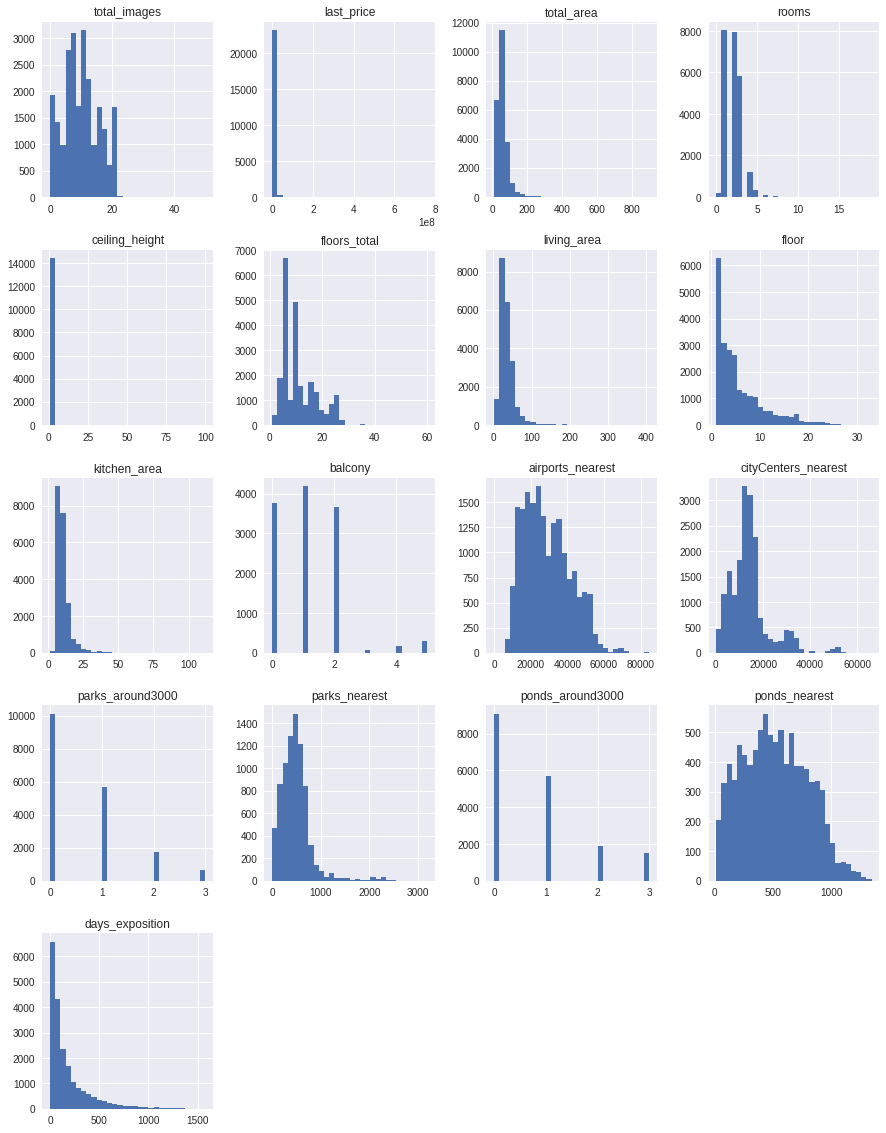

In [331]:
df.hist(figsize=(15,20), bins=30)
plt.show()

<div class="alert alert-block alert-info"> 
    
Следует отметить, что большинство столбцов имеют распределение, похожее на лог-нормальное, есть длинные хвосты преимущественно справа. 
1. Столбец со стоимостью квартиры выглядит крайне подозрительно, справа очевидно есть очень большой выброс.  
2. Столбец с высотой потолков также имеет очень странные значения-выбросы
3. Также есть подозрительные значения в столбце с общим количеством этажей. Учитывая, что в Ленинградской области и Санкт-Петербурге не так много высоких домов, в данных точно есть выбросы.
4. Самое большое количество пропусков находится в столбце is_apartment
5. Наиболее похожи на нормальное распределение столбцы с расстоянием до ближайшего аэропорта и с расстоянием до центра города
    </div>

### Выполните предобработку данных

Посмотрим на пропуски в данных. Визуализируем процент пропусков в виде столбиковой диаграммы

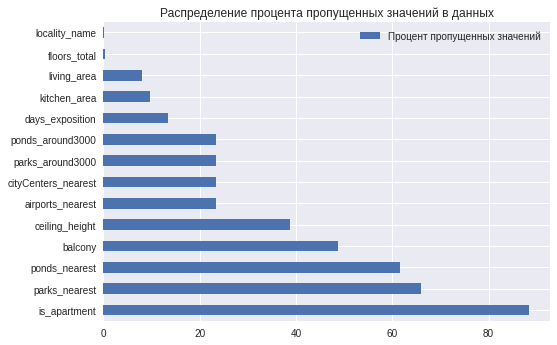

In [332]:
missed_values_df = df.isna()
missed_values_mean = missed_values_df.mean()
(pd.DataFrame((missed_values_mean[missed_values_mean > 0] * 100).round(2), 
             columns=['Процент пропущенных значений'])
.sort_values('Процент пропущенных значений', ascending=False)
.plot(kind='barh', title='Распределение процента пропущенных значений в данных'))
plt.show()

Получим список столбцов, с которыми следует поработать в разрезе анализа пропущенных значений

In [333]:
list(pd.DataFrame((df.isna().mean()[df.isna().mean() > 0] * 100).round(2), 
             columns=['Процент пропущенных значений'])
.sort_values('Процент пропущенных значений', ascending=False).index)

['is_apartment',
 'parks_nearest',
 'ponds_nearest',
 'balcony',
 'ceiling_height',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_around3000',
 'ponds_around3000',
 'days_exposition',
 'kitchen_area',
 'living_area',
 'floors_total',
 'locality_name']

Проверим пропущенные значения на взаимосвязь

<AxesSubplot:>

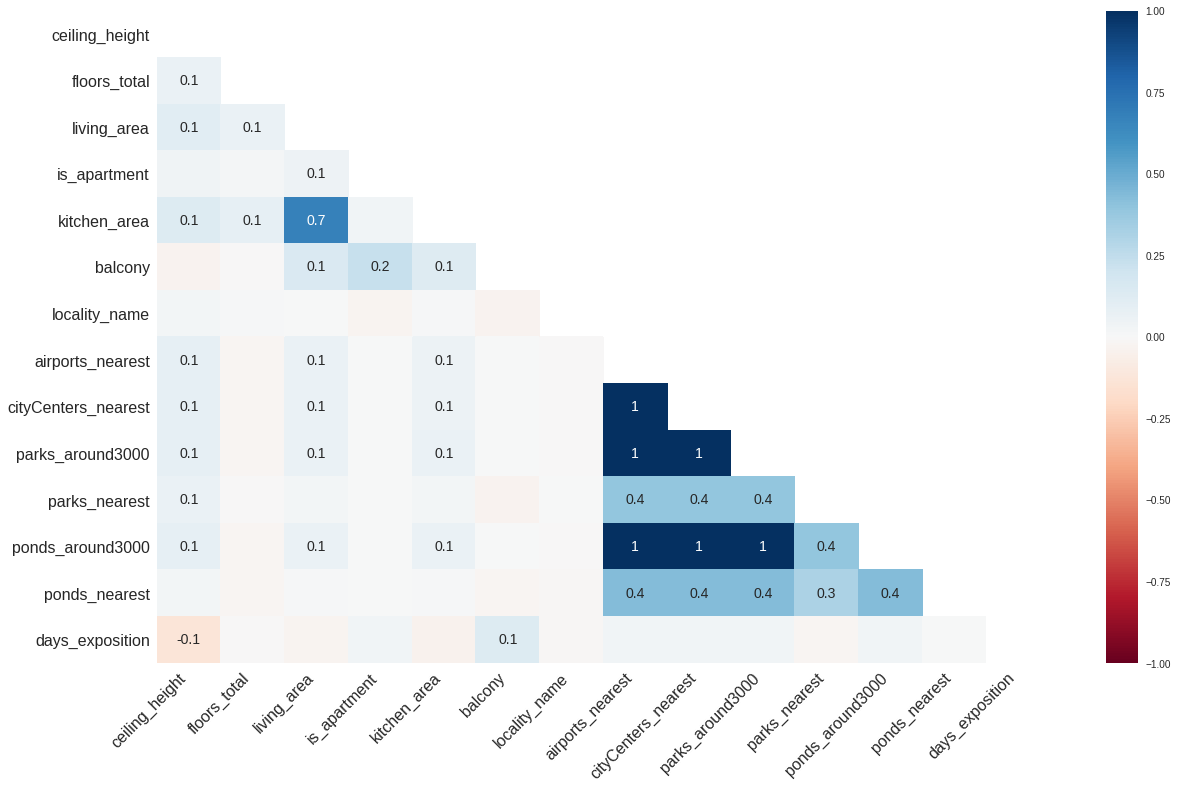

In [334]:
msno.heatmap(df)

1. Наблюдается сильная взаимосвязь в разрезе пропусков в столбцах `ponds_around3000`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`. 
2. Кроме того, логично предположить, что пропуски в столбце `parks_nearest` могут влечь за собой пропуски в столбце `parks_around3000`, аналогично для пары столбцов `ponds_nearest` и `ponds_around3000`

## Работа со столбцом `locality_name`

In [335]:
print(f'Процент пропусков: {(df.locality_name.isna().mean() * 100).round(2)}%')

Процент пропусков: 0.21%


Пропусков здесь очень немного, поэтому их можно легко удалить

In [336]:
df.dropna(subset=['locality_name'], inplace=True)

## Работа со столбцом `is_apartment`

Больше всего пропусков в столбце `is_apartment`.

In [337]:
print(f'Процент пропусков: {(df.is_apartment.isna().mean() * 100).round(2)}%')

Процент пропусков: 88.33%


In [338]:
df.is_apartment.value_counts()

False    2710
True       50
Name: is_apartment, dtype: int64

In [339]:
temp = df[df.is_apartment.isna()].copy()

Как правило, апартаменты имеют свободную планировку. Проверим, как распределилсь пропуски в столбце `is_apartment` по признаку свободной планировки

<AxesSubplot:title={'center':'Распределение пропусков в столбце is_apartment по признаку свободной планировки'}, ylabel='open_plan'>

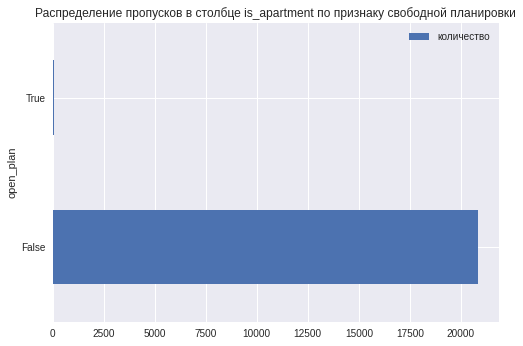

In [340]:
ptemp = (temp
         .pivot_table(index='open_plan', values=['last_price'], aggfunc='count')
         .sort_values('last_price', ascending=False))
ptemp.columns = ['количество']
ptemp.plot(kind='barh', title='Распределение пропусков в столбце is_apartment по признаку свободной планировки')

Отчетливо видно, что пропуски в большинстве случаев имеют несвободную планировку

Выполним категоризацию общей площади 

In [341]:
def categorize_total_area(total_area):
    if total_area <= 20:
        return '$S \leq 20 $'
    elif 20 < total_area <= 40:
        return '$S\in(20; 40]$'
    elif 40 < total_area <= 52:
        return '$S\in(40; 52]$'
    elif 52 < total_area <= 70:
        return '$S\in(52; 70]$'
    else:
        return '$S \geq 70$'        

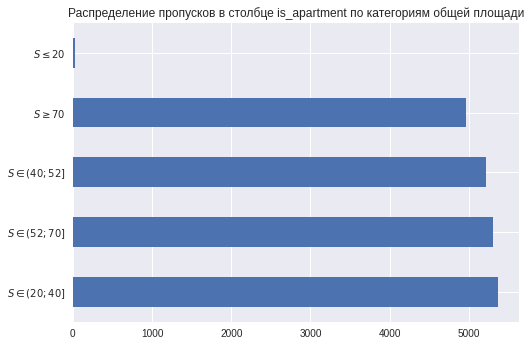

In [342]:
temp['total_area_group'] = temp['total_area'].apply(categorize_total_area)
(temp['total_area_group']
 .value_counts()
 .plot(kind='barh', title='Распределение пропусков в столбце is_apartment по категориям общей площади'))
plt.show()

Видно, что большинство квартир в пропусках по столбцу is_apartment - это немаленькие квартиры

Теперь посмотрим, где находится большинство пропусков в этом столбце

<AxesSubplot:title={'center':'Распределение пропусков в столбце is_apartment по населенным пунктам'}, ylabel='locality_name'>

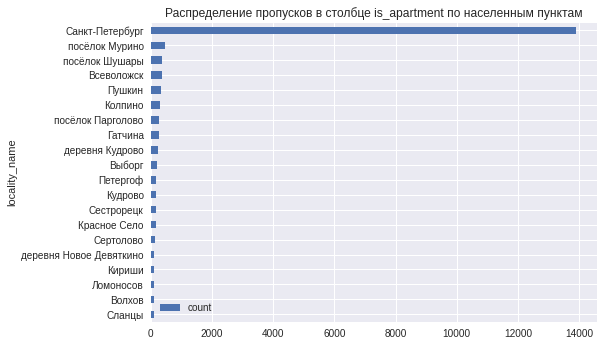

In [343]:
(temp
            .pivot_table(index='locality_name', values='last_price', aggfunc='count')
            .sort_values('last_price')
            .set_axis(['count'], axis=1)
            .query('count > 100')
            .plot(kind='barh', title='Распределение пропусков в столбце is_apartment по населенным пунктам'))

Из столбиковой диаграммы видно, что большая самое большое количество пропусков в исследуемом столбце находятся в Санкт-Петербурге

Последнее, проверим сильно ли отличается медианная цена квартир с пропусками в той же категории по общей площади от медианной цены всех квартир в этой же категории общей площади. Для этого применим категоризацию ко всему датасету

In [344]:
df['total_area_group'] = df['total_area'].apply(categorize_total_area)

In [345]:
piv_temp = (temp
            .pivot_table(index=['total_area_group'], values=['last_price'], aggfunc=['median', 'mean'])
            .set_axis(['медианная цена', 'средняя цена'], axis=1)
           )
piv_temp

,медианная цена,средняя цена
total_area_group,,
$S \geq 70$,9360000.0,1.356516e+07
$S \leq 20 $,1900000.0,2.043500e+06
$S\in(20; 40]$,3300000.0,3.322667e+06
$S\in(40; 52]$,4100000.0,4.147867e+06
$S\in(52; 70]$,5350000.0,5.549434e+06


In [346]:
piv_df = df.pivot_table(index=['total_area_group'], values=['last_price'], aggfunc=['median', 'mean'])
piv_df.columns = ['медианная цена', 'средняя цена']
piv_temp / piv_df

,медианная цена,средняя цена
total_area_group,,
$S \geq 70$,1.006452,1.007317
$S \leq 20 $,1.000000,1.024476
$S\in(20; 40]$,1.000000,0.998911
$S\in(40; 52]$,1.000000,0.999648
$S\in(52; 70]$,1.000000,1.002073


Из сводной таблицы можно заключить, что медианная цена практически идентичная, есть небольшие колебания в средней цене

Следует также проверить самую малую по площади категорию. Возможно, что представленные в этой категории квартиры могли бы иметь статус апаратаменты-студия

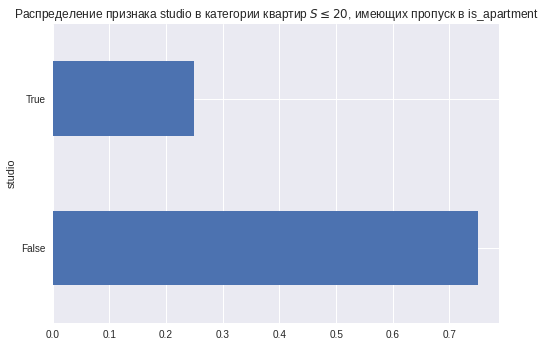

In [347]:
piv_temp = (temp
            .loc[temp.total_area_group == '$S \leq 20 $', ['studio', 'total_area']]
            .pivot_table(index='studio', values='total_area', aggfunc='count')
            .set_axis(['количество'], axis=1)
           )
piv_temp['доля'] = piv_temp['количество'] / piv_temp['количество'].sum()
piv_temp['доля'].plot(kind='barh', title='Распределение признака studio в категории квартир $S \leq 20 $, имеющих пропуск в is_apartment')
plt.show()

Большинство квартир ($\approx 75\%$) в этой категории не являются студией.

Выясним наиболее частый вариант по категории общей площади в пропусках и во всем датасете

In [348]:
pd.DataFrame(df['total_area_group'].value_counts())

,total_area_group
$S\in(20; 40]$,6000
$S\in(52; 70]$,5993
$S\in(40; 52]$,5906
$S \geq 70$,5716
$S \leq 20 $,35


In [349]:
pd.DataFrame(temp['total_area_group'].value_counts())

,total_area_group
$S\in(20; 40]$,5369
$S\in(52; 70]$,5302
$S\in(40; 52]$,5222
$S \geq 70$,4969
$S \leq 20 $,28


Медианное значение общей площади в пропусках и во всем датасете

In [350]:
df[~df.is_apartment.isna()][['total_area', 'last_price']].median()

total_area         54.0
last_price    4750000.0
dtype: float64

In [351]:
temp[['total_area', 'last_price']].median()

total_area         52.0
last_price    4600000.0
dtype: float64

Теперь исследуем медиану общей площади тех квартир, где нет пропусков в столбце is_apartment

In [352]:
df.query('is_apartment == True')[['total_area', 'last_price']].median()

total_area         64.0
last_price    6900000.0
dtype: float64

In [353]:
df.query('is_apartment == False')[['total_area', 'last_price']].median()

total_area         53.85
last_price    4700000.00
dtype: float64

Несмотря на то, что часть датасета, где заполнен столбец is_apartment достаточно мала, можно сделать вывод, что медианное значение общей площади в пропусках ближе к медианному значению общей площади квартир, которые не являются апартаментами. Поэтому пропуски в этом столбце будем заполнять значением False

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Исходя из проведенного анализа можно сделать вывод, что 
    
1. Пропуски в исследуемом столбце преимущественно присущи квартирам в Санкт-Петербурге
2. Большинство квартир имеют общую площадь не менее 20 квадратных метров
3. Преимущественно несвободная планировка
4. Типичное значение общей площади квартир в пропусках ближе к категории квартир, не имеющих статус апартаментов
5. Мода категории площади - $S > 70$
6. В категории квартир, чья площадь составляет менее 20 квадратных метров, только 26 % имеют статус студии, остальные же являются малыми жилыми площадями</div>

In [354]:
df.is_apartment.fillna(False, inplace=True)

## Работа со столбцом `parks_around3000`,

`parks_around3000` — число парков в радиусе 3 км<p>


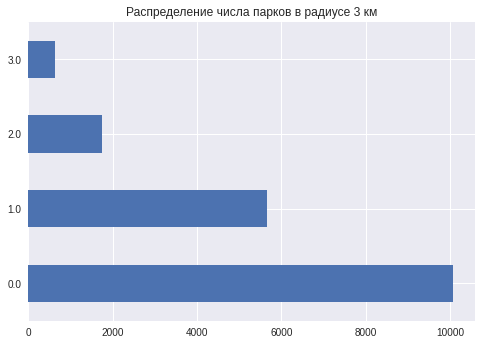

In [355]:
(df
 .parks_around3000.value_counts()
 .plot(kind='barh', title='Распределение числа парков в радиусе 3 км'))
plt.show()

In [356]:
missed_parks_around3000 = df.parks_around3000.isna()

In [357]:
print(f'Процент пропусков: {(missed_parks_around3000.mean() * 100).round(2)}%')

Процент пропусков: 23.3%


Вспомним о возможной взаимосвязи пропусков и посмотрим на пропуски в других столбцах в разрезе пропусков в столбце parks_around3000

In [358]:
(
    df[missed_parks_around3000]
    .isna()
    .mean()
    .sort_values(ascending=False) * 100
).round(2) 


ponds_nearest           100.00
ponds_around3000        100.00
parks_nearest           100.00
parks_around3000        100.00
cityCenters_nearest     100.00
airports_nearest        100.00
balcony                  49.11
ceiling_height           46.62
days_exposition          15.68
kitchen_area             12.94
living_area              11.29
floors_total              0.18
total_images              0.00
locality_name             0.00
open_plan                 0.00
last_price                0.00
studio                    0.00
is_apartment              0.00
floor                     0.00
rooms                     0.00
first_day_exposition      0.00
total_area                0.00
total_area_group          0.00
dtype: float64

In [359]:
def categorize_locality(row):
    if 'садо' in row['locality'].lower():
        return 'СНТ'
    elif 'деревня' in row['locality'].lower():
        return 'деревня'
    elif 'село' in row['locality'].lower() or  'посё' in row['locality'].lower():
        return 'село'
    else:
        return 'другое'

<AxesSubplot:title={'center':'Распределение количества населенных пунктов в пропусках parks_around3000 в зависимости от типа'}, ylabel='type'>

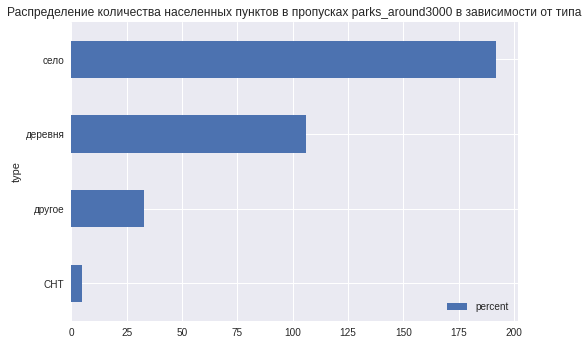

In [360]:
compare_table = ((df[missed_parks_around3000].locality_name.value_counts() / df.locality_name.value_counts() * 100)
                 .reset_index()
                 .set_axis(['locality', 'percent'], axis=1)
                 .query('percent == 100')
)

compare_table['type'] = compare_table.apply(categorize_locality, axis=1)

(compare_table
     .pivot_table(index='type', values='percent', aggfunc='count')
     .sort_values('percent')
     .plot(kind='barh', title="Распределение количества населенных пунктов в пропусках parks_around3000 в зависимости от типа")
)

На диаграмме видно, что большую часть пропусков в этом столбце составляют сёла и деревни. Вероятнее всего, пропуски в этом столбце намеренные, так как говорить о парках в этих населенных пунтках не совсем корректно. Поэтому будем заполнять пропуски в этом столбце нулями.

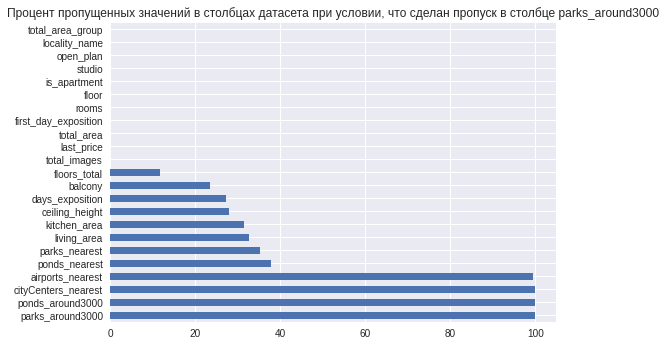

In [361]:
((df[missed_parks_around3000].isna().sum() / df.isna().sum() * 100)
 .round(2)
 .sort_values(ascending=False)
 .plot(kind='barh', title='Процент пропущенных значений в столбцах датасета при условии, что сделан пропуск в столбце parks_around3000')
)
plt.show()

Отметим, что практически все пропуски столбцов cityCenters_nearest, ponds_around3000, airoports_nearest находятся в срезе данных, где пропущены значения в столбце parks_around3000

In [362]:
piv_miss = pd.DataFrame()
for c in ['ponds_around3000', 'parks_around3000', 'ponds_nearest', 'parks_nearest', 'airports_nearest', 'cityCenters_nearest']:
    t = df[df[c].isna()].isna().sum() / df.isna().sum() * 100
    piv_miss[f'Пропуск в {c}'] = t[t > 99].round(2)
piv_miss

,Пропуск в ponds_around3000,Пропуск в parks_around3000,Пропуск в ponds_nearest,Пропуск в parks_nearest,Пропуск в airports_nearest,Пропуск в cityCenters_nearest
airports_nearest,99.57,99.57,99.86,99.64,100.00,99.57
cityCenters_nearest,99.98,99.98,100.00,99.98,99.98,100.00
parks_around3000,100.00,100.00,100.00,100.00,100.00,100.00
ponds_around3000,100.00,100.00,100.00,100.00,100.00,100.00


<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Исходя из анализа столбцов, можно заключить следующее

1. Если есть пропуск в столбце ponds_around3000, то он обязательно есть в столбце parks_around3000
2. Если допущен пропуск в ponds_nearest, то он обязательно есть в столбце cityCenters_nearest, parks_around3000, ponds_around3000
3. Если допущен пропуск в parks_nearest, то он обязательно есть в столбце parks_around3000, ponds_around3000, а также с большой вероятностью присутствует в столбце cityCenters_nearest
4. Большинство пропусков в столбцах airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000 находятся в сёлах и деревнях
5. Столбцы parks_around3000, ponds_around3000 могут быть заполнены нулями, а столбцы ponds_nearest, parks_nearest, cityCenters_nearest, airports_nearest не подлежат заполнению. 
</div>

В таблице сверху не все значения равны 100%, так как, вероятно, имеет место быть случайному пропуску, примеры которого можно увидеть снизу.

In [363]:
df[(~df.parks_around3000.isna())&(df.airports_nearest.isna())].locality_name.value_counts()

Санкт-Петербург    24
Name: locality_name, dtype: int64

In [364]:
df[(df.airports_nearest.isna())&(~df.parks_nearest.isna())].locality_name.value_counts()

Санкт-Петербург    20
Name: locality_name, dtype: int64

In [365]:
df.parks_around3000.fillna(0, inplace=True)
df.ponds_around3000.fillna(0, inplace=True)

df.parks_around3000 = df.parks_around3000.astype(int)
df.ponds_around3000 = df.ponds_around3000.astype(int)

## Работа со столбцом `balcony`

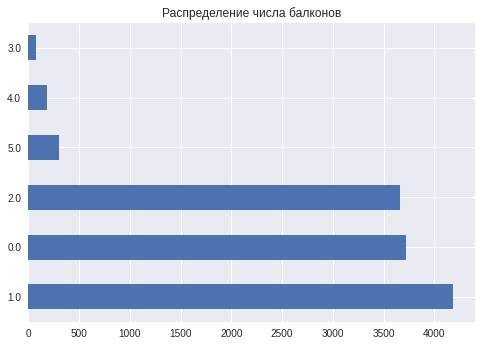

In [366]:
(df
 .balcony
 .value_counts()
 .plot(kind='barh', title='Распределение числа балконов'))
plt.show()

In [367]:
print(f'Процент пропусков: {(df.balcony.isna().mean() * 100).round(2)}%')

Процент пропусков: 48.68%


In [368]:
(df
       .loc[df.balcony.isna()]
       .pivot_table(index=['total_area_group', 'locality_name'],values='last_price', aggfunc=['count'])
       .set_axis(['count'], axis=1).
       query('count > 200')
)

,,count
total_area_group,locality_name,
$S \geq 70$,Санкт-Петербург,2397
$S\in(20; 40]$,Санкт-Петербург,1657
$S\in(40; 52]$,Санкт-Петербург,1813
$S\in(52; 70]$,Санкт-Петербург,1824


Видно, что большинство квартир с пропусками в столбце balcony находятся в Санкт-Петербурге. Скорее всего, пропуск в этом столбце означает то, что в данной квартире нет балконов. Такие пропуски можно заменить на число 0

In [369]:
df.balcony.fillna(0, inplace=True)
df.balcony = df.balcony.astype(int)

## Работа со столбцом `ceiling_height`

In [370]:
print(f'Процент пропусков: {(df.ceiling_height.isna().mean() * 100).round(2)}%')

Процент пропусков: 38.73%


In [371]:
missed_ceiling_height = df.ceiling_height.isna()

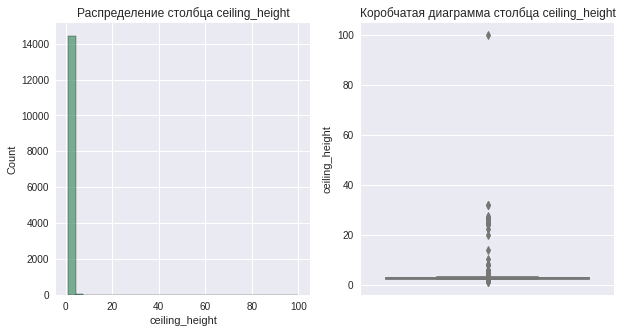

In [372]:
plot_graphics(df, 'ceiling_height')

In [373]:
df.ceiling_height.describe()

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Высота потолков не может быть нулевой, поэтому попробуем сгруппировать квартиры по двум столбцам total_area_group и locality_name и посчитаем медианные значения по каждой группе. А затем полученными значениями заполним пропуски. Необходимо учесть, что в случае если медиана в какой-либо из групп - это неопределенное значение, то необходимо поменять способ заполнения пропуска. Так как total_area_group сформирован на основе столбца с непрерывными значениями, не имеющего пропуски, то будем использовать медианное значение соответствующей группы total_area_group

In [374]:
df.pivot_table(index=['total_area_group', 'locality_name'], values='ceiling_height', aggfunc='median')

ceiling_height
total_area_group locality_name                                          
$S \geq 70$      Бокситогорск                                      2.800
                 Волосово                                          2.500
                 Волхов                                            3.000
                 Всеволожск                                        2.700
                 Выборг                                            3.000
...                                                                  ...
$S\in(52; 70]$   посёлок городского типа имени Свердлова           2.550
                 село Копорье                                      2.500
                 село Павлово                                      2.775
                 село Путилово                                     2.600
                 село Русско-Высоцкое                              2.575

[646 rows x 1 columns]

In [375]:
for gropers_names, vals in df.groupby(['total_area_group'])['ceiling_height']:
    filter_query = ((df.total_area_group == gropers_names) & (missed_ceiling_height))
    if vals.median() is None:
        df.loc[df.total_area_group == gropers_names[0], 'ceiling_height'].median()
    else:
        df.loc[filter_query, 'ceiling_height'] = vals.median()

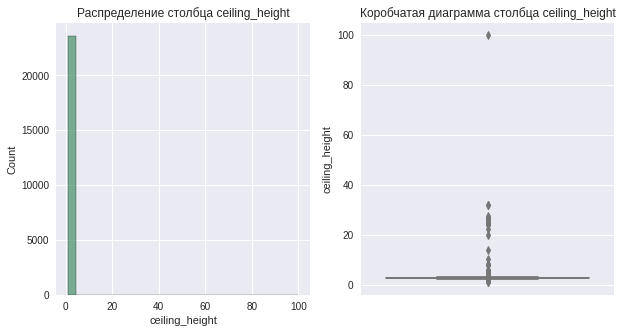

In [376]:
plot_graphics(df, 'ceiling_height')

Возможно, была совершена ошибка при вводе, и, например, высота 26 это 2.6

In [377]:
np.array(sorted(df.ceiling_height.unique()))

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

In [378]:
df.ceiling_height = df.ceiling_height.apply(lambda x: x / 10 if x >= 20 and x < 100 and x % 1 == 0 else x)

Так как в Питере есть богатый исторический жилой фонд, то высота потолков может сильно варьироваться. Поэтому ограничим высоту потолков величиной 5 метров

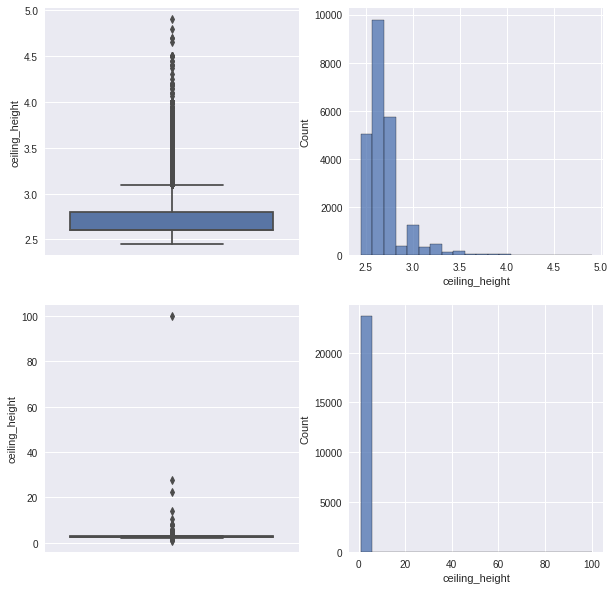

In [379]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.boxplot(data=df.query('2.4 < ceiling_height < 5'), y='ceiling_height', ax=ax[0][0])
sns.histplot(data=df.query('2.4 < ceiling_height < 5'), x='ceiling_height', bins=20, ax=ax[0][1])
sns.boxplot(data=df, y='ceiling_height', ax=ax[1][0])
sns.histplot(data=df, x='ceiling_height', bins=20, ax=ax[1][1])
plt.show()

In [380]:
ceiling_height_outliers = detect_outliers(df, 'ceiling_height', strategy='iqr')

In [381]:
ceiling_height_outliers.ceiling_height.describe()

count    1418.000000
mean        3.482482
std         2.749061
min         1.000000
25%         3.200000
50%         3.300000
75%         3.500000
max       100.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

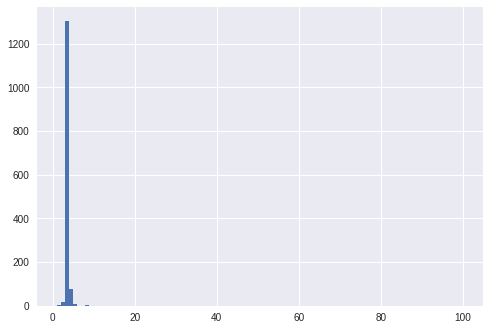

In [382]:
ceiling_height_outliers.ceiling_height.hist(bins=100)

Потолки менее 2 метров или больше 5 - это большая редкость, если, конечно, продается не дворец или часовня. Таких объявлений всего 32, поэтому их можно удалить

In [383]:
df.query('2.4 < ceiling_height < 5').ceiling_height.describe()

count    23587.000000
mean         2.693904
std          0.221019
min          2.450000
25%          2.600000
50%          2.600000
75%          2.800000
max          4.900000
Name: ceiling_height, dtype: float64

Ограничим данные

In [384]:
df = df.query('2.4 < ceiling_height < 5')

Полезное наблюдение: у апартаментов медианное значение высоты больше чем у других квартир

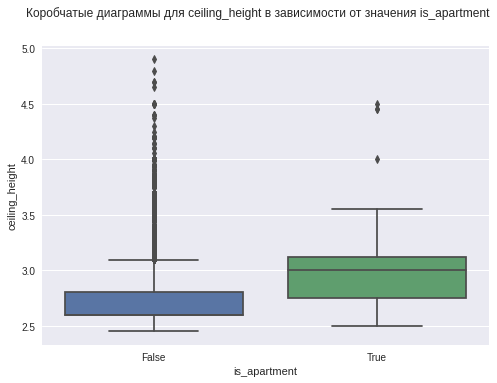

In [385]:
sns.boxplot(
    data=df.query('2 < ceiling_height < 5'),
    y='ceiling_height', 
    x='is_apartment').figure.suptitle('Коробчатые диаграммы для ceiling_height в зависимости от значения is_apartment')
plt.show()

## Работа со столбцом `floors_total`

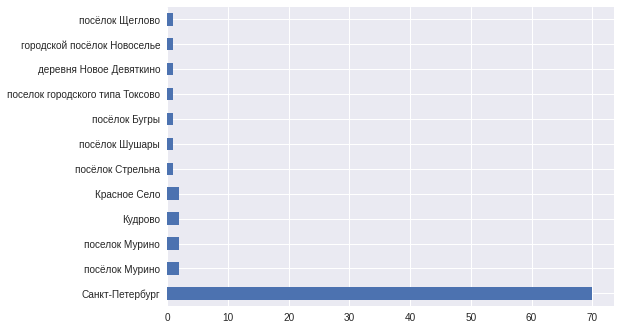

In [386]:
(df.loc[(df.floors_total.isna())]
 .locality_name
 .value_counts()
 .plot(kind='barh'))
plt.show()

In [387]:
print(f'Процент пропусков: {(df.floors_total.isna().mean() * 100).round(2)}%')

Процент пропусков: 0.36%


Так как процент пропусков в этом столбце достаточно мал, то мы можем удалить их без всякого вреда для распределения данных

In [388]:
df["floors_total"].fillna(0, inplace=True)

In [389]:
floors_total_outliers = detect_outliers(df, 'floors_total', 'iqr')
floors_total_outliers

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
397,15,5990000.0,54.0,2018-03-22T00:00:00,2,2.60,36.0,21.4,28,False,...,1,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,11.0,$S\in(52; 70]$
871,14,7777777.0,75.0,2017-11-16T00:00:00,2,2.80,35.0,40.5,23,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,169.0,$S \geq 70$
1060,10,5200000.0,50.0,2015-11-06T00:00:00,2,2.60,35.0,39.0,15,False,...,2,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,281.0,$S\in(40; 52]$
1697,11,3550000.0,28.0,2018-02-08T00:00:00,1,2.65,34.0,18.0,23,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,410.0,$S\in(20; 40]$
1917,13,10150000.0,74.0,2017-11-17T00:00:00,2,2.80,35.0,34.4,30,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,NaN,$S \geq 70$
2253,12,3800000.0,45.5,2018-06-28T00:00:00,2,2.88,60.0,27.4,4,False,...,0,Кронштадт,67763.0,49488.0,2,342.0,3,614.0,166.0,$S\in(40; 52]$
2966,9,4300000.0,37.0,2017-08-08T00:00:00,1,2.60,35.0,14.0,15,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,50.0,$S\in(20; 40]$
4855,12,5500000.0,50.0,2017-06-22T00:00:00,1,2.80,35.0,22.0,4,False,...,0,Санкт-Петербург,18627.0,20339.0,1,609.0,3,145.0,537.0,$S\in(40; 52]$
5749,20,3590000.0,25.0,2017-08-30T00:00:00,0,2.80,35.0,NaN,26,False,...,2,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,198.0,$S\in(20; 40]$
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,2.70,36.0,41.0,13,False,...,5,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,38.0,$S \geq 70$


По информации в выбросах видно, что большинство квартир находятся в 35-этажном доме в Санкт-Петербурге. Это могут быть вполне реальные данные. Однако 60-этажный небоскреб в Кронштадте не выглядит очень реалистично, также как и 52-этажный дом в Санкт-Петербурге

In [390]:
df.drop(index=[2253, 16731], inplace=True, errors='ignore')
floors_total_outliers.drop(index=[2253, 16731], inplace=True, errors='ignore')

In [391]:
df.loc[floors_total_outliers.index, 'floors_total'] = 35

In [392]:
df.floors_total = df.floors_total.astype(int)

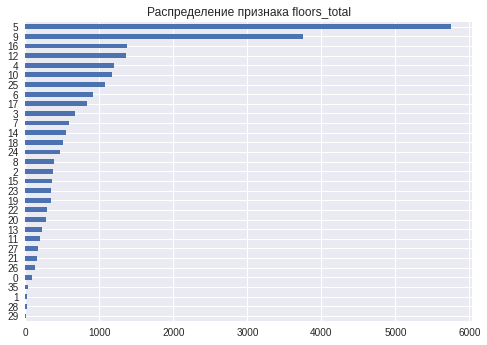

In [393]:
(df
 .floors_total
 .value_counts()
 .sort_values()
 .plot(kind='barh', title='Распределение признака floors_total'))
plt.show()

## Работа со столбцами `kitchen_area` и `living_area`

Данные столбцы будем заполнять через медианные значения соотношений kitchen_area и living_area к общей площади. Группировать данные будем через количество комнат и категорию общей площади

In [394]:
df.loc[:, 'kitchen_area_part'] = df['kitchen_area'] / df['total_area']
df.loc[:, 'living_area_part'] = df['living_area'] / df['total_area']

In [395]:
median_parts = df.pivot_table(index=['rooms', 'total_area_group'], values=['kitchen_area_part', 'living_area_part'], aggfunc='median').median()
median_parts

kitchen_area_part    0.120243
living_area_part     0.653103
dtype: float64

In [396]:
na_kitchen = df.kitchen_area.isna()
na_living = df.living_area.isna()

df.loc[na_kitchen, 'kitchen_area'] = df.loc[na_kitchen, 'total_area'] * median_parts[0]
df.loc[na_living, 'living_area'] = df.loc[na_living, 'total_area'] * median_parts[1]

Но даже после заполнения пропусков в данных столбцах остаются странные данные. Где сумма кухонной и жилой площадей больше чем заявленная общая площадь. Можно предположить, что в данных присутствуют квартиры без санузла

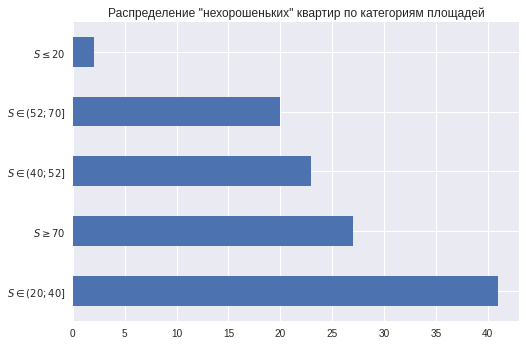

In [397]:
(df
 .query('kitchen_area + living_area > total_area')['total_area_group']
 .value_counts()
 .plot(kind='barh', title='Распределение "нехорошеньких" квартир по категориям площадей'))
plt.show()

Их не очень много, и они практически не влияют на распределения столбцов kitchen_area и living_area, поэтому от них можно избавиться

In [398]:
df = df.query('kitchen_area + living_area <= total_area')

Изучим столбец kitchen_area. Виден длинный правый хвост

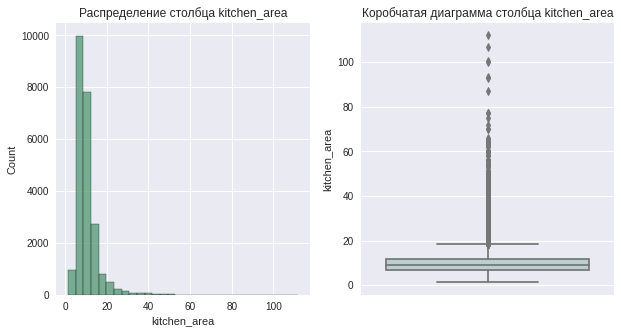

In [399]:
plot_graphics(df, 'kitchen_area')

In [400]:
kitchen_area_outliers = detect_outliers(df, 'kitchen_area', 'iqr')
kitchen_area_outliers.kitchen_area.describe()

count    1373.000000
mean       27.328923
std        10.628711
min        18.550000
25%        20.000000
50%        23.600000
75%        30.000000
max       112.000000
Name: kitchen_area, dtype: float64

Выбросов здесь не так много, в основном подозрительными кажутся большие кухонные площади. Можно сделать отсечку по хвосту распределения

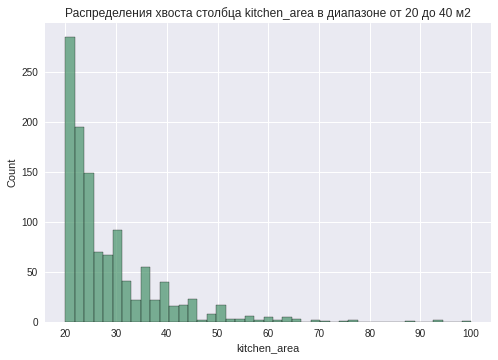

In [401]:
sns.histplot(df, x='kitchen_area', binrange=(20, 100), color='#519872').set_title('Распределения хвоста столбца kitchen_area в диапазоне от 20 до 40 м2')
plt.show()

Удалив выбросы, мы не сильно повлияем на медианное значение цены

In [402]:
(df.query('kitchen_area < 55').last_price.median(), df.last_price.median())

(4642000.0, 4650000.0)

Большинство выбросов - это квартиры в Петербурге

In [403]:
kitchen_area_outliers = df.query('kitchen_area >= 55')
kitchen_area_outliers.pivot_table(index=['locality_name', 'rooms'], values='last_price', aggfunc=['count', 'median'])

count       median
                      last_price   last_price
locality_name   rooms                        
Пушкин          2              1   25900000.0
                3              2   10495000.0
Санкт-Петербург 1              2   39592664.0
                2              1   65850000.0
                3             12   48422250.0
                4              7   41900000.0
                5              5   65000000.0
                6              2   35500000.0
                7              2  220000000.0
                12             1  420000000.0
                15             1   65000000.0

In [404]:
df = df.query('kitchen_area < 50')

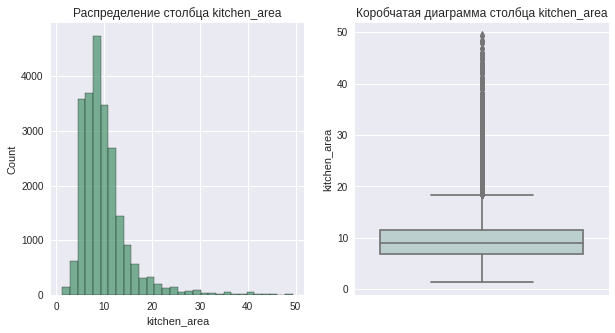

In [405]:
plot_graphics(df, 'kitchen_area')

Изучим столбец living_area

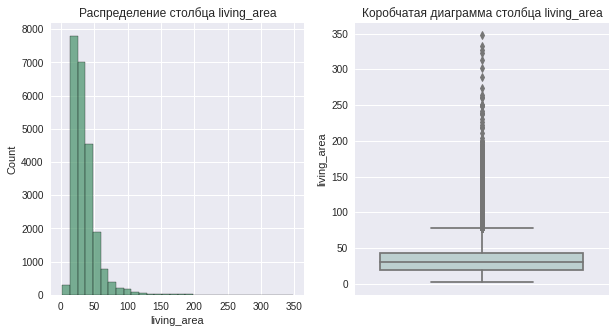

In [406]:
plot_graphics(df, 'living_area')

Снова виден длинный правый хвост. Исследуем его

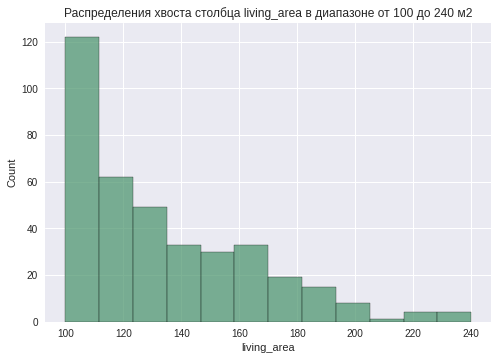

In [407]:
sns.histplot(df, x='living_area', binrange=(100, 240), color='#519872').set_title('Распределения хвоста столбца living_area в диапазоне от 100 до 240 м2')
plt.show()

Медиана меняется, но не критично

In [408]:
(df.query('living_area < 185').last_price.median(), df.last_price.median())

(4600000.0, 4626540.0)

In [409]:
df.query('living_area >= 185').living_area.describe()

count     41.000000
mean     237.382282
std       45.494785
min      187.000000
25%      198.543448
50%      230.000000
75%      260.000000
max      347.500000
Name: living_area, dtype: float64

In [410]:
df = df.query('living_area < 185')

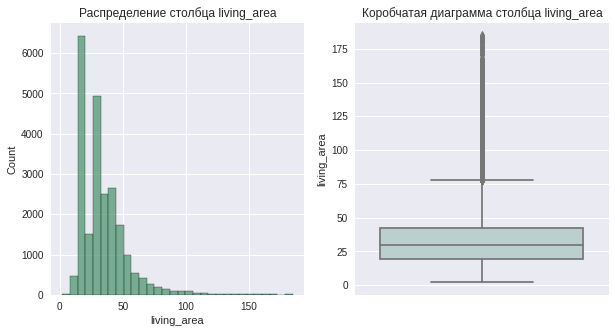

In [411]:
plot_graphics(df, 'living_area')

## Работа со столбцом `total_area`

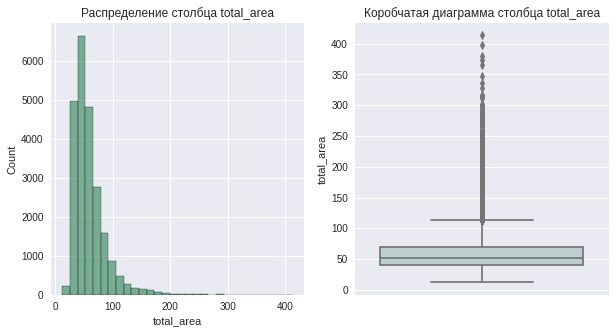

In [412]:
plot_graphics(df, 'total_area')

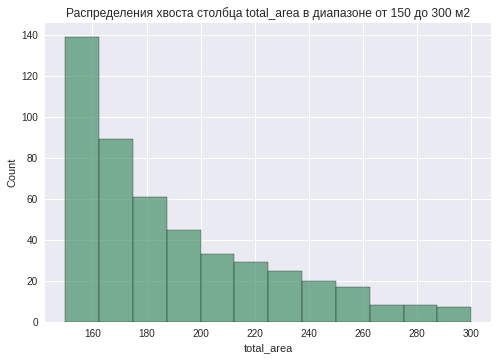

In [413]:
sns.histplot(df, x='total_area', binrange=(150, 300), color='#519872').set_title('Распределения хвоста столбца total_area в диапазоне от 150 до 300 м2')
plt.show()

In [414]:
total_area_outliers = detect_outliers(df, 'total_area', 'iqr')
total_area_outliers.total_area.describe()

count    1201.000000
mean      154.274363
std        43.572676
min       112.900000
25%       122.700000
50%       140.700000
75%       170.000000
max       413.500000
Name: total_area, dtype: float64

In [415]:
(df.query('total_area < 250').last_price.median(), df.last_price.median())

(4600000.0, 4600000.0)

In [416]:
df.query('total_area >= 250').total_area.describe()

count     53.000000
mean     288.485849
std       39.953213
min      250.000000
25%      259.200000
50%      280.000000
75%      300.000000
max      413.500000
Name: total_area, dtype: float64

In [417]:
df = df.query('total_area < 250')

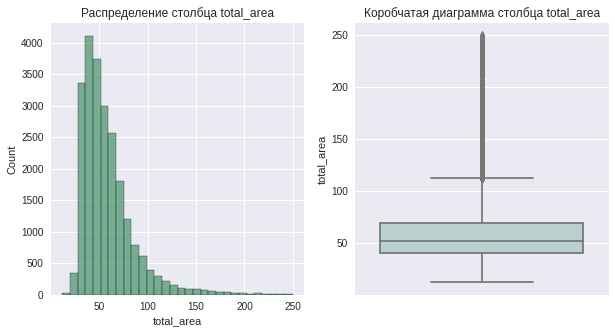

In [418]:
plot_graphics(df, 'total_area')

## Работа со столбцом `days_exposition`

In [419]:
print(f'Процент пропусков: {(df.days_exposition.isna().mean() * 100).round(2)}%')

Процент пропусков: 13.4%


В этом столбце пропуски могут быть по техническим причинам. Например, объявление может быть до сих пор в ротации, поэтому значение в этом столбце для него еще не существует

In [420]:
df.days_exposition.describe()

count    20194.000000
mean       180.316332
std        219.346912
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

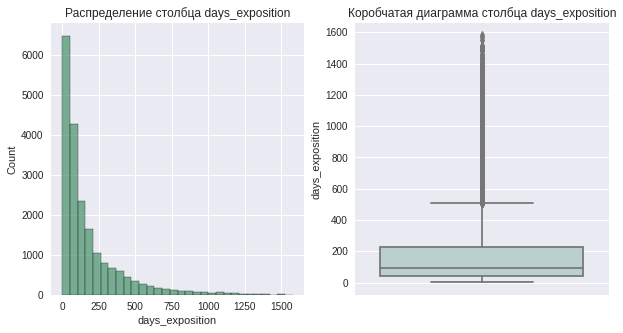

In [421]:
plot_graphics(df, 'days_exposition')

In [422]:
days_exposition_outliers = detect_outliers(df, 'days_exposition', 'iqr')
days_exposition_outliers.days_exposition.describe()

count    1657.000000
mean      766.341581
std       222.961166
min       508.000000
25%       585.000000
50%       703.000000
75%       892.000000
max      1580.000000
Name: days_exposition, dtype: float64

In [423]:
days_exposition_outliers

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,kitchen_area_part,living_area_part
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16,51.000000,8,False,...,18863.0,16028.0,1,482.0,2,755.0,NaN,$S \geq 70$,0.231481,0.472222
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.60,5,34.300000,4,False,...,21741.0,13933.0,1,90.0,2,574.0,558.0,$S\in(52; 70]$,0.148214,0.612500
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.80,24,46.762207,22,False,...,23982.0,11634.0,0,NaN,0,NaN,NaN,$S \geq 70$,0.263966,NaN
17,6,4180000.0,36.00,2016-09-09T00:00:00,1,2.60,17,16.500000,7,False,...,33564.0,14616.0,0,NaN,1,859.0,571.0,$S\in(20; 40]$,0.305556,0.458333
23,11,2950000.0,32.00,2016-10-29T00:00:00,1,2.60,9,17.700000,9,False,...,15414.0,14211.0,2,517.0,1,190.0,615.0,$S\in(20; 40]$,0.190625,0.553125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23691,11,9470000.0,72.90,2016-10-13T00:00:00,2,2.75,25,40.300000,7,False,...,19424.0,4489.0,0,NaN,1,806.0,519.0,$S \geq 70$,0.145405,0.552812
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5,73.300000,3,False,...,24665.0,4232.0,1,796.0,3,381.0,NaN,$S \geq 70$,0.103356,0.547792
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.60,3,29.700000,1,False,...,NaN,NaN,0,NaN,0,NaN,NaN,$S\in(52; 70]$,NaN,0.523810
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17,50.125690,12,False,...,39140.0,10364.0,2,173.0,3,196.0,602.0,$S \geq 70$,0.303583,NaN


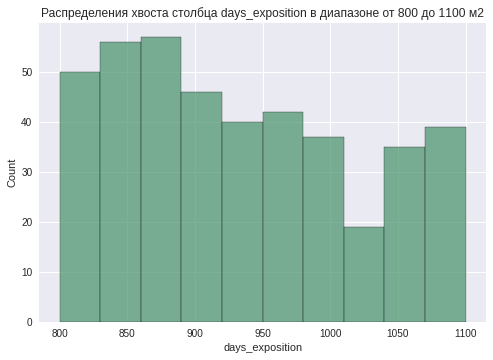

In [424]:
sns.histplot(df, x='days_exposition', binrange=(800, 1100), color='#519872').set_title('Распределения хвоста столбца days_exposition в диапазоне от 800 до 1100 м2')
plt.show()

In [425]:
df = process_outliers(df, 'days_exposition', 'iqr', 'fill_na')

Ограничим время жизни объявления сроком жизни в три года

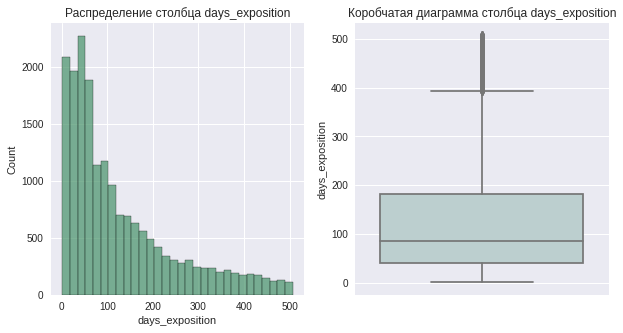

In [426]:
plot_graphics(df, 'days_exposition')

## Работа со столбцом `first_day_exposition`

Изменим тип данных

In [427]:
df.first_day_exposition

0        2019-03-07T00:00:00
1        2018-12-04T00:00:00
2        2015-08-20T00:00:00
3        2015-07-24T00:00:00
4        2018-06-19T00:00:00
                ...         
23694    2017-03-21T00:00:00
23695    2018-01-15T00:00:00
23696    2018-02-11T00:00:00
23697    2017-03-28T00:00:00
23698    2017-07-21T00:00:00
Name: first_day_exposition, Length: 23319, dtype: object

In [428]:
df.first_day_exposition = pd.to_datetime(
    df.first_day_exposition,
    format='%Y-%m-%dT%H:%M:%S')

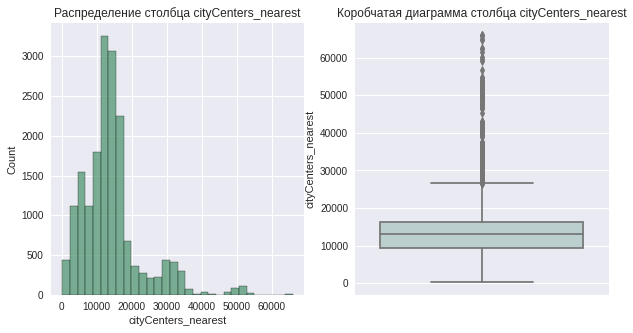

In [429]:
plot_graphics(df, 'cityCenters_nearest')

В целом, выбросов тут как таковых тоже нет, Санкт-Петербург достаточно большой город, поэтому расстояние от некоторых его районов до центра может быть достаточно большим (например, Колпино)

In [430]:
(detect_outliers(df, 'cityCenters_nearest', 'iqr')
 .pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc=['median', 'count'])
 .set_axis(['median', 'count'], axis=1)
 .query('count > 20')
)

,median,count
locality_name,,
Зеленогорск,53381.0,24
Колпино,32018.0,334
Красное Село,29142.0,173
Кронштадт,49597.5,94
Ломоносов,51677.0,132
Павловск,32683.0,38
Петергоф,33771.0,200
Пушкин,30235.5,242
Сестрорецк,34821.0,182


## Работа со столбцом `last_price`

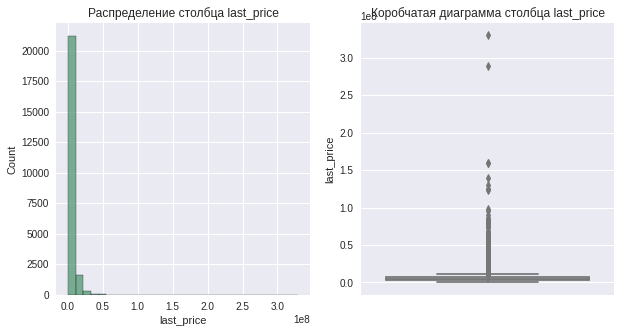

In [431]:
plot_graphics(df, 'last_price')

In [432]:
last_price_outliers = detect_outliers(df, 'last_price', 'iqr')
last_price_outliers.last_price.describe()

count    1.937000e+03
mean     2.032394e+07
std      1.604369e+07
min      1.165000e+07
25%      1.315000e+07
50%      1.560000e+07
75%      2.180000e+07
max      3.300000e+08
Name: last_price, dtype: float64

In [433]:
q25 = df.last_price.quantile(.25)
q75 = df.last_price.quantile(.75)
iqr = q75 - q25
df = df.query('last_price < @q75 + 4 * @iqr')

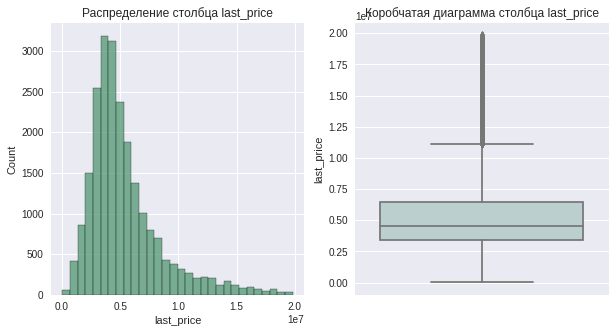

In [434]:
plot_graphics(df, 'last_price')

Большая часть данных - квартиры в Петербурге. Цены, представленные в датасете, вполне соответствуют реальным данным

## Работа со столбцом `airports_nearest`

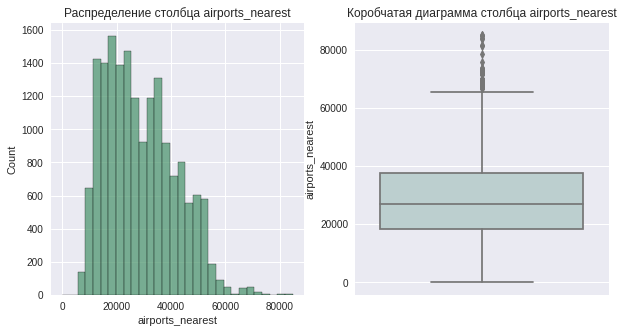

In [435]:
plot_graphics(df, 'airports_nearest')

In [436]:
detect_outliers(df, 'airports_nearest', 'iqr').pivot_table(index='locality_name', values='airports_nearest', aggfunc=['median', 'mean'])

,median,mean
,airports_nearest,airports_nearest
locality_name,,
Зеленогорск,72284.0,73443.043478
Кронштадт,68482.0,68425.393939
посёлок Молодёжное,84665.0,84430.200000


Однако в действительности эти данные не являются выбросами, расстояния от, например, Кронштадта и Зеленогорска до аэропорта Пулково соответствуют картографическим данным

## Работа со столбцом `parks_nearest`

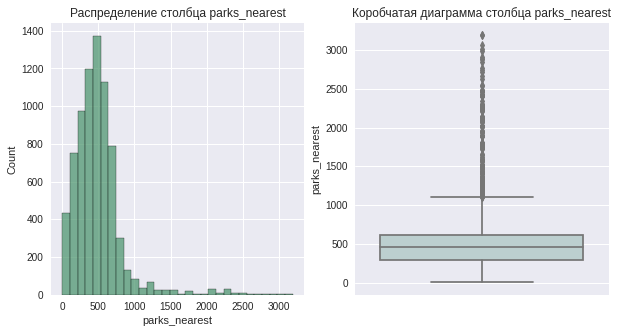

In [437]:
plot_graphics(df, 'parks_nearest')

In [438]:
parks_nearest_outliers = detect_outliers(df, 'parks_nearest', 'iqr')
parks_nearest_outliers.parks_nearest.describe()

count     298.000000
mean     1721.600671
std       501.506053
min      1103.000000
25%      1270.000000
50%      1514.000000
75%      2102.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [439]:
(parks_nearest_outliers
 .pivot_table(index='locality_name', values='parks_nearest', aggfunc=['median', 'count'])
 .set_axis(['median', 'count'], axis=1)
 .query('count > 5')
)

,median,count
locality_name,,
Колпино,1400.0,13
Петергоф,1887.0,9
Санкт-Петербург,1514.0,274


В целом, ничего критичного нет, однак большинство квартир находятся недалеко от парков

## Работа со столбцом `ponds_nearest`

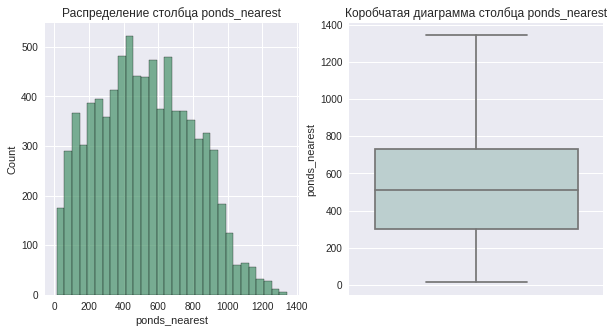

In [440]:
plot_graphics(df, 'ponds_nearest')

Образцово показательная диаграмма, выбросов вообще не наблюдается

In [441]:
df = df.drop(['kitchen_area_part', 'living_area_part'], axis=1, errors='ignore')

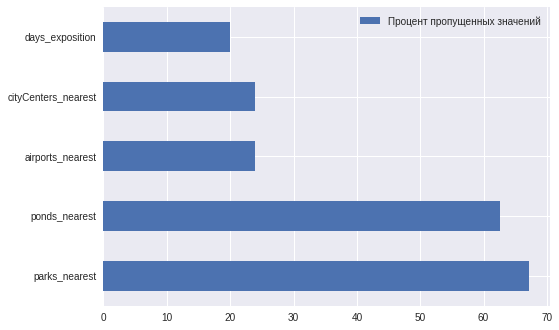

In [442]:
missed_values_df = df.isna()
missed_values_mean = missed_values_df.mean()
(pd.DataFrame((missed_values_mean[missed_values_mean > 0] * 100).round(2), 
             columns=['Процент пропущенных значений'])
.sort_values('Процент пропущенных значений', ascending=False)
.plot(kind='barh'))
plt.show()

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
После обработки пропусков данные стали выглядеть явно лучше. Географические данные и время жизни объявления заполнить не удалось. Природа этих пропусков техническая и требуется дополнительная информация для их заполнения. Например, для заполнения пропусков в столбце airports_nearest в Санкт-Петербурге нужно знать точный адрес квартиры или хотя бы район, так как город большой и расстояние может сильно меняться в зависимости от района. С парками и водоёмами ситуация аналогичная. Возможно, имеет смысл попробовать восстановить расстояние до аэропорта для квартир, находящихся в малых населенных пунктах с помощью агрегации и поиска медианного расстояния. Но, вероятно, подразумевается, что эти данные должны быть картографически точными, поэтому требуются дополнительные сведения. Также исследованы аномалии, по возможности восстановлены корректные значения, но болшинство аномалий были удалены, но предварительно был проведен их анализ
</div>

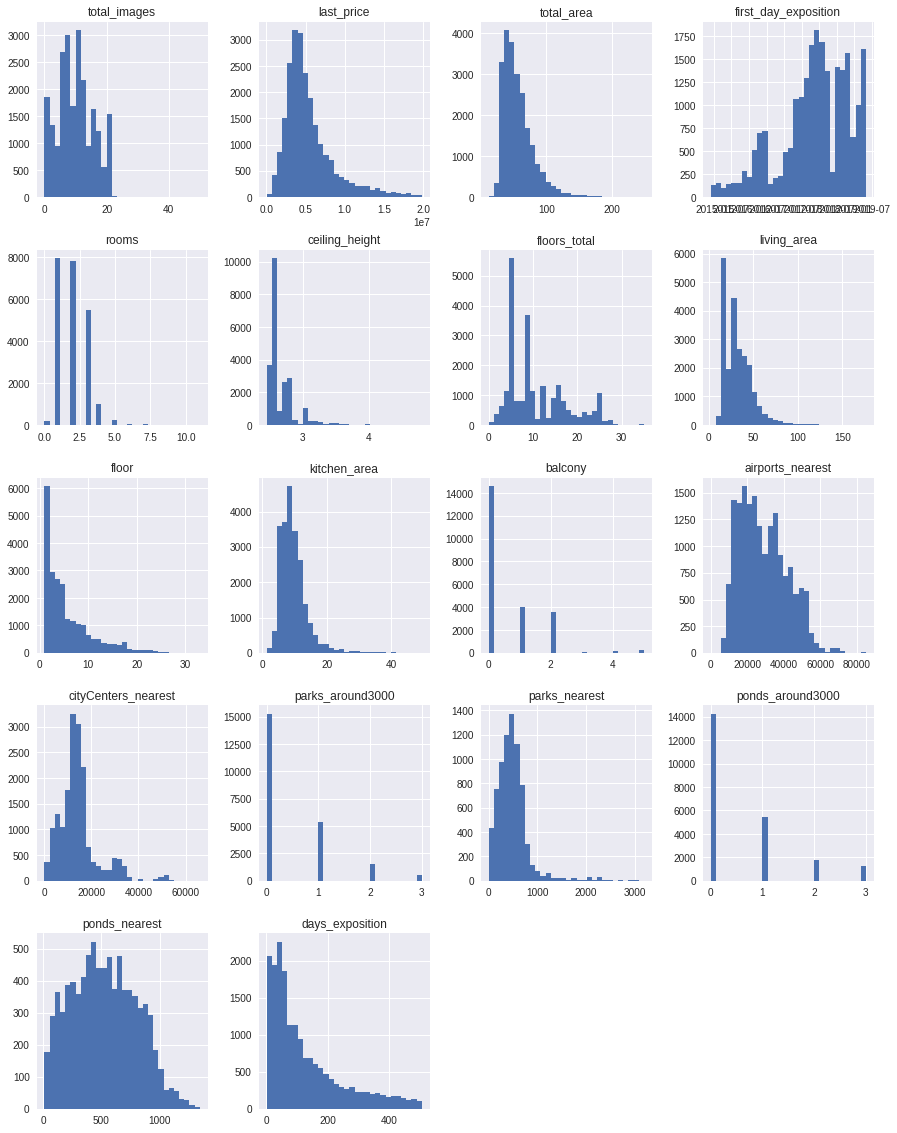

In [443]:
df.hist(figsize=(15, 20), bins=30)
plt.show()

In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22731 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22731 non-null  int64         
 1   last_price            22731 non-null  float64       
 2   total_area            22731 non-null  float64       
 3   first_day_exposition  22731 non-null  datetime64[ns]
 4   rooms                 22731 non-null  int64         
 5   ceiling_height        22731 non-null  float64       
 6   floors_total          22731 non-null  int64         
 7   living_area           22731 non-null  float64       
 8   floor                 22731 non-null  int64         
 9   is_apartment          22731 non-null  bool          
 10  studio                22731 non-null  bool          
 11  open_plan             22731 non-null  bool          
 12  kitchen_area          22731 non-null  float64       
 13  balcony         

### Обработка дубликатов

Попробуем найти явные дубли

In [445]:
df.duplicated().sum()

0

In [446]:
df.locality_name.value_counts()

Санкт-Петербург                                            14899
посёлок Мурино                                               513
посёлок Шушары                                               438
Всеволожск                                                   392
Пушкин                                                       355
                                                           ...  
деревня Рапполово                                              1
поселок городского типа Рябово                                 1
садоводческое некоммерческое товарищество Лесная Поляна        1
посёлок Петро-Славянка                                         1
поселок Сумино                                                 1
Name: locality_name, Length: 364, dtype: int64

In [447]:
replacers = [('ё', 'е'), 
             ('деревня ', ''), 
             ('городской ', ''), 
             ('коттеджный ', ''), 
             ('поселок ', ''), 
             ('село ', ''),
             ('поселок городского типа ', ''),
             ('городского типа ', ''),
             ('поселок при железнодорожной станции ', 'станция '),
             ('станции ', 'станция '),
             ('садоводческое некоммерческое товарищество ', 'СНТ '),
             ('садовое товарищество ', 'СНТ '),
             ('при железнодорожной станция ', 'станция ')]

for r in replacers:
    df.locality_name = df.locality_name.str.replace(*r)

In [448]:
df.locality_name.value_counts()

Санкт-Петербург    14899
Мурино               580
Кудрово              469
Шушары               438
Всеволожск           392
                   ...  
Шум                    1
Ялгино                 1
Жилпоселок             1
Сижно                  1
Хязельки               1
Name: locality_name, Length: 308, dtype: int64

<AxesSubplot:title={'center':'Распределение количества квартир в населенных пунктах (после обработки дубликатов)'}, ylabel='locality_name'>

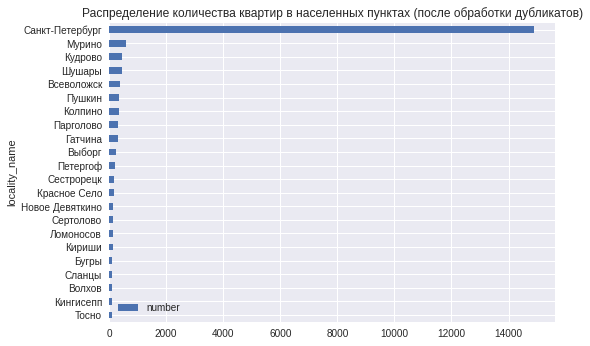

In [449]:
(df
 .pivot_table(index='locality_name', values='last_price', aggfunc='count')
 .set_axis(['number'], axis=1)
 .query('number > 100')
 .sort_values('number')
 .plot(kind='barh', title='Распределение количества квартир в населенных пунктах (после обработки дубликатов)')
)

<div style="color:#FCFAEE ;background-color:#507687" class="alert alert-block alert-info"> 
    
    
1. Явных дубликатов не было найдено
2. C помощью дополнительного анализа были выявлены неявные дубликаты в столбце с названиями населенных пунктов
Примеры: используется разное написание слова поселок (буквы е и ё), некоторые населенные пункты составлены по-разному. Например, "поселок гордского типа П" и "городской поселок П", а также "поселок Мурино" и "Мурино"
3. После унификации названий населеннных пунктов удалось добиться 308 уникальных значений вместо 364
</div>

### Добавьте в таблицу новыe столбцы

In [450]:
df['first_day_exposition_weekday'] = df.first_day_exposition.dt.weekday

<AxesSubplot:title={'center':'Распределение дней недели в столбце first_day_exposition'}>

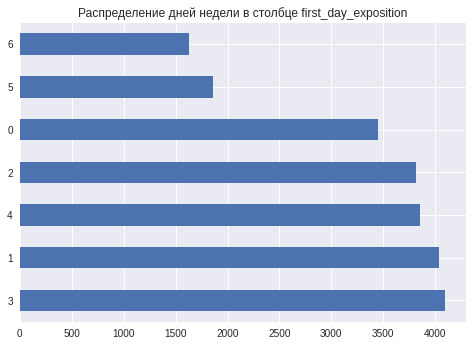

In [451]:
df['first_day_exposition_weekday'].value_counts().plot(kind='barh', title='Распределение дней недели в столбце first_day_exposition')

In [452]:
df['price_per_square'] = df['last_price'] / df['total_area']

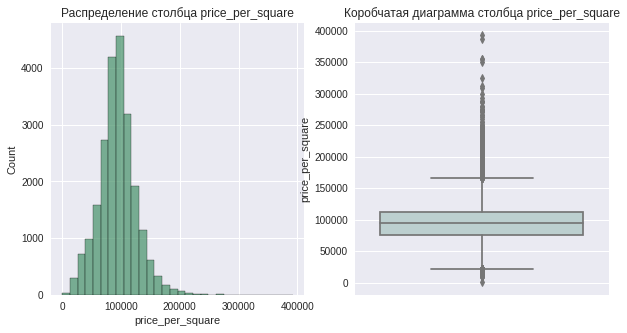

In [453]:
plot_graphics(df, 'price_per_square')

In [454]:
month_map = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь',
}

In [455]:
df['first_day_exposition_month'] = df.first_day_exposition.dt.month
df['first_day_exposition_month'] = df['first_day_exposition_month'].apply(lambda x: month_map[x])

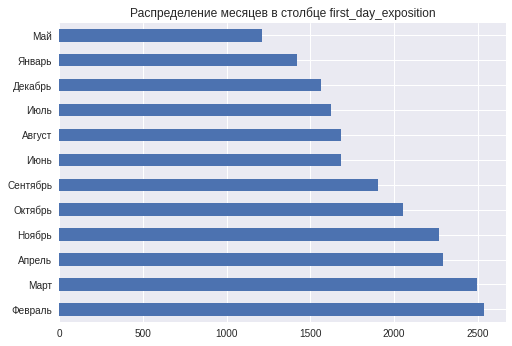

In [456]:
(df['first_day_exposition_month']
 .value_counts()
 .plot(kind='barh', title='Распределение месяцев в столбце first_day_exposition'))
plt.show()

In [457]:
df['first_day_exposition_year'] = df.first_day_exposition.dt.year

<AxesSubplot:title={'center':'Распределение году в столбце first_day_exposition'}>

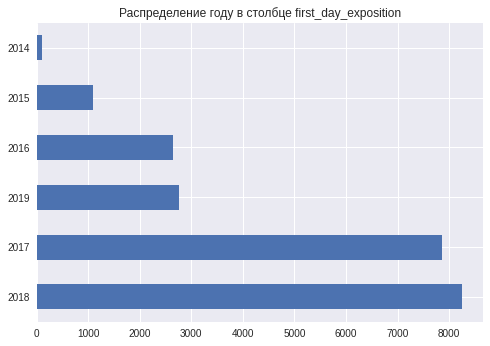

In [458]:
df['first_day_exposition_year'].value_counts().plot(kind='barh', title='Распределение году в столбце first_day_exposition')

In [459]:
def categorize_floor(row):
    if row['floors_total'] == row['floor']:
        return 'последний'
    elif row['floor'] == 1:
        return 'первый'
    else:
        return 'другой'

In [460]:
df['floor_category'] = df.apply(categorize_floor, axis=1)

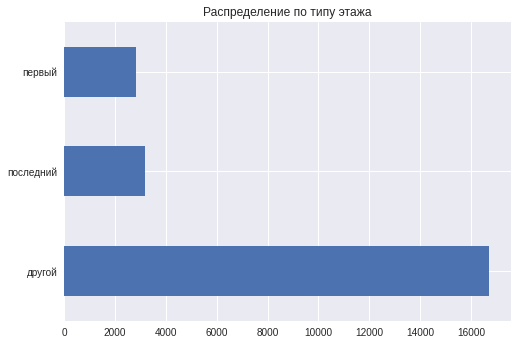

In [461]:
(df['floor_category']
 .value_counts()
 .plot(kind='barh', title='Распределение по типу этажа'))
plt.show()

In [462]:
df['cityCenters_nearest_km'] = df['cityCenters_nearest'] / 1000

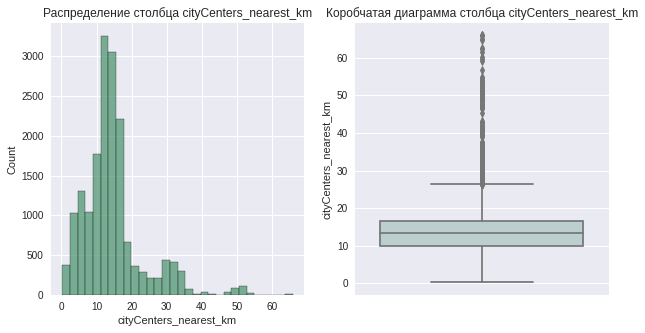

In [463]:
plot_graphics(df, 'cityCenters_nearest_km')

### Проведите исследовательский анализ данных

#### Иcследование скорости продажи квартиры 

Исследуем, насколько быстро продавались квартиры. Для этого посмотрим на распределение в столбце days_exposition

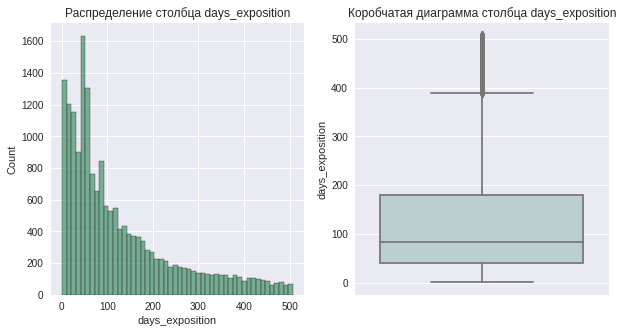

In [464]:
plot_graphics(df, 'days_exposition', bins=50)

In [465]:
df.days_exposition.describe()

count    18201.000000
mean       127.026207
std        120.073948
min          1.000000
25%         41.000000
50%         84.000000
75%        180.000000
max        507.000000
Name: days_exposition, dtype: float64

Из полученных статистик можно сделать вывод, что медианное время жизни публикации составляет 84 дня, а среднее значение - 127 дней

Отметим, что медианное значение времени жизни объявлений квартир, находящихся на первом этаже, выше чем на других этажах, это в основном характерно для квартир площадью больше 20 квадратных метров. Кроме того, медианные значения различны так же и для квартир с разным количеством комнат. 

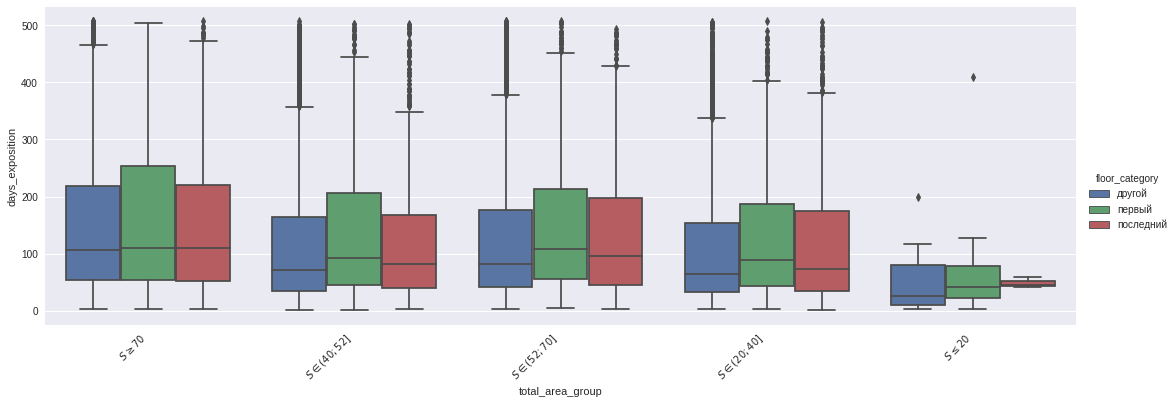

In [466]:
sns.catplot(
    data=df[['days_exposition', 'total_area_group', 'floor_category']],
    x="total_area_group",
    y="days_exposition",
    hue="floor_category",
    aspect=3,
    kind="box",
).set_xticklabels(rotation=45, horizontalalignment="right");

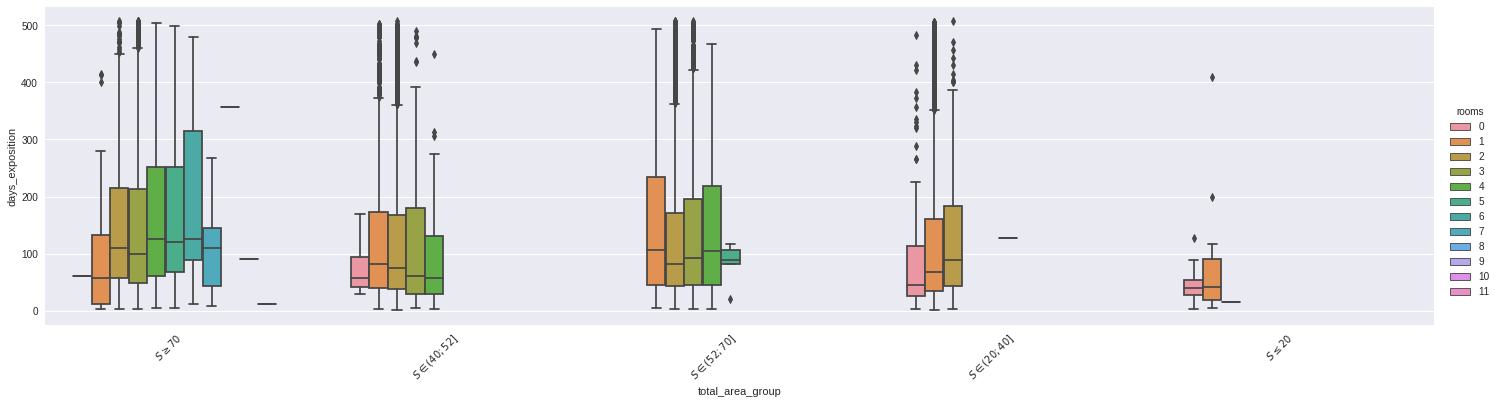

In [467]:
sns.catplot(
    data=df[['days_exposition', 'total_area_group', 'rooms']],
    x="total_area_group",
    y="days_exposition",
    hue="rooms",
    aspect=4,
    kind="box",
).set_xticklabels(rotation=45, horizontalalignment="right");

Построим сводную таблицу, где сгруппируем данные о времени жизни публикации по категории площади, типу этажа и количеству комнат.

In [468]:
piv_df = (df
          .pivot_table(index=['total_area_group', 'floor_category', 'rooms'], values='days_exposition',
                       aggfunc={'days_exposition': [('median_days_exposition', 'median'), 'count', 'min', ('q25', lambda x: x.quantile(.25)), ('q75', lambda x: x.quantile(.75)), 'max'],
    }
                      ).fillna(0))
piv_df.q25.quantile(.25), piv_df.median_days_exposition.median(), piv_df.q75.quantile(.75)

(30.0, 89.00000000000001, 215.3125)

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Итак, после агрегации мы получили типичное значение - 89 дней (медианное значение медианных значений), а также границы нормального времени жизни объявления - [30, 215]. Выходящие за эти границы значения превышают скорость обычной продажи </div>

In [469]:
df.query('~(days_exposition >= 30 and days_exposition <= 215)').days_exposition.shape[0] / df.days_exposition.shape[0]

0.5095684307773525

Таких значений немало, около 50 процентов. Визуализируем на гистограмме, красным отмечена медиана, синим - границы нормального диапазона

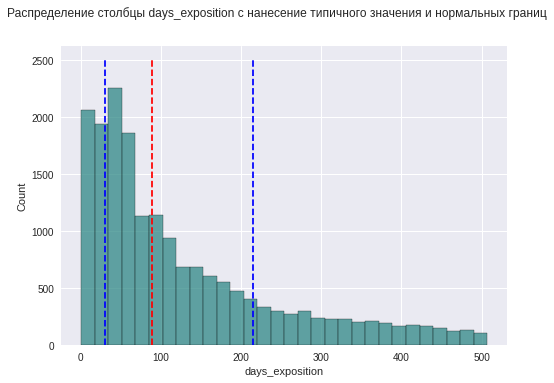

In [470]:
(sns.histplot(data=df, x='days_exposition', bins=30, color='#2F8886')
 .figure
 .suptitle('Распределение столбцы days_exposition c нанесение типичного значения и нормальных границ'))
plt.vlines(piv_df.q25.quantile(.25), 0, 2500, color='blue', ls='dashed')
plt.vlines(piv_df.q75.quantile(.75), 0, 2500, color='blue', ls='dashed')
plt.vlines(piv_df.median_days_exposition.median(), 0, 2500, color='red', ls='dashed')
plt.show()

#### Оценка влияния факторов на `last_price`

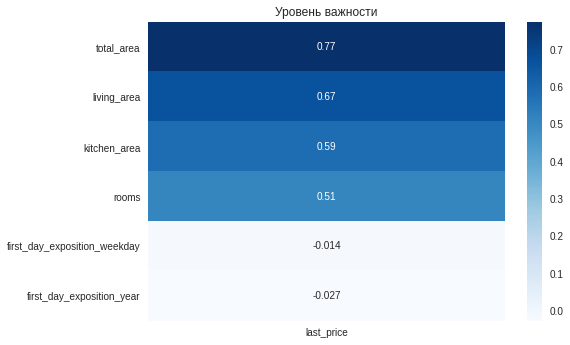

In [471]:
(sns.heatmap(df[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'first_day_exposition_weekday', 'first_day_exposition_year']].corr()[['last_price']].query('last_price < 1'),
            annot=True,
            cmap="Blues")
.set_title('Уровень важности'))
plt.show()

Коэффициент корреляции показал, что наибольшую корреляцию с ценой квартиры имеет общая площадь жилья. 

In [472]:
piv = (df
       .pivot_table(index='total_area_group', values='last_price', 
                    aggfunc={
                        'last_price': [('q5', lambda x: x.quantile(.05)),
                                       ('median', 'median'), 
                                       ('q95', lambda x: x.quantile(.95))]}))
piv

,median,q5,q95
total_area_group,,,
$S \geq 70$,8500000.0,4100000.0,16699400.0
$S \leq 20 $,1900000.0,1068300.0,3340000.0
$S\in(20; 40]$,3300000.0,1450000.0,5000000.0
$S\in(40; 52]$,4100000.0,1650000.0,6690000.0
$S\in(52; 70]$,5341000.0,2200000.0,9200000.0


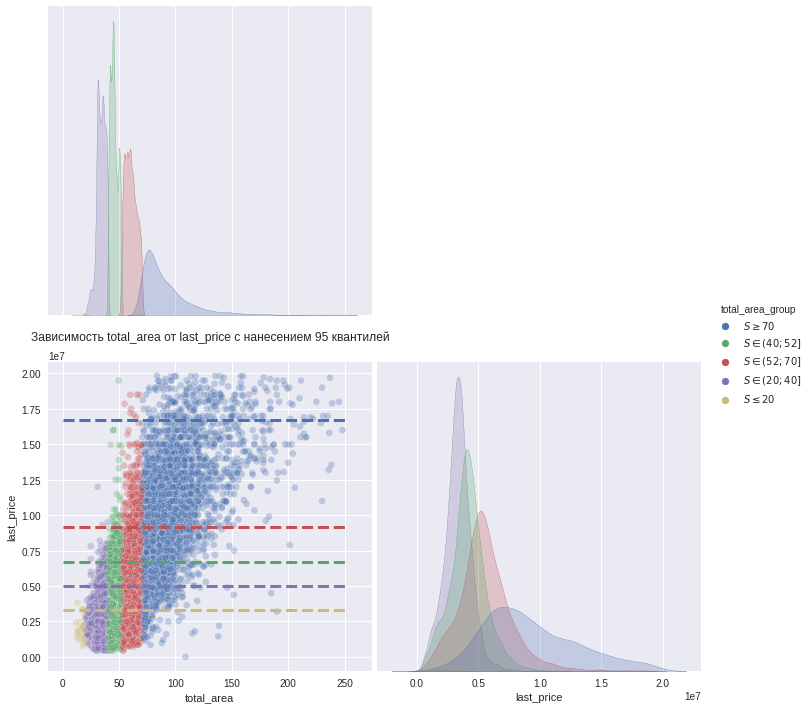

In [473]:
g = sns.pairplot(
    df,
    vars=["total_area", "last_price"],
    corner=True,
    hue="total_area_group",
    height=5,
    plot_kws={'alpha':0.3}
);

g.fig.subplots_adjust(hspace=0.15)

g.axes[1][0].set_title('Зависимость total_area от last_price с нанесением 95 квантилей', y=1.05)
for p in zip(g.palette, g.hue_names):
    g.axes[1][0].hlines(y=piv.loc[p[1], 'q95'], xmin=0, xmax=250, color=p[0], lw=3, ls='--') 

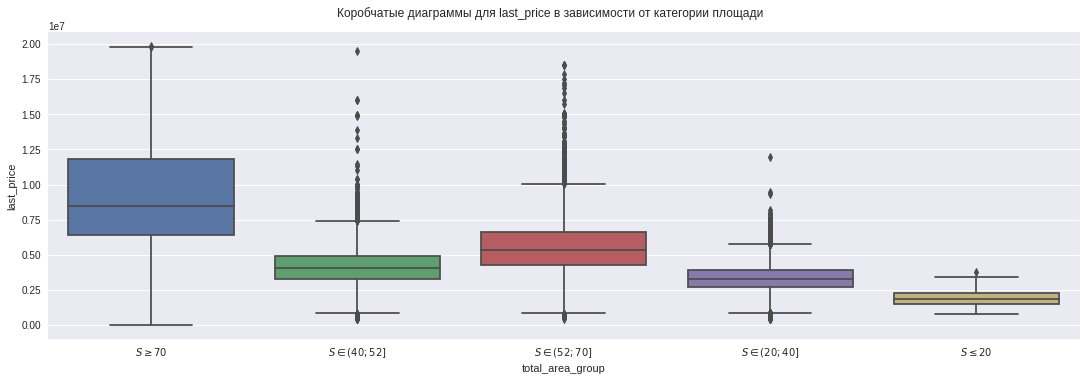

In [474]:
g = sns.catplot(
    data=df[['total_area_group', "total_area", "last_price"]],
    x="total_area_group",
    y="last_price",
    aspect=3,
    kind="box",
).fig.suptitle('Коробчатые диаграммы для last_price в зависимости от категории площади', y=1.01)

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
    
1. Цена действительно сильно зависит от общей площади квартиры. Особенно ярко это выражается для квартир общей площадью до 100 квадратных метров
2. Медианные значения различных по категории площади квартир легко различимы
3. Верхняя отсечка по цене, по которой можно идентифицировать 95 процентов квартир в той или иной категории по площади легко различимы на графике</div>

In [475]:
df.living_area.quantile([0.25, 0.5, 0.75])

0.25    19.0
0.50    30.0
0.75    41.5
Name: living_area, dtype: float64

In [476]:
def categorize_living_area(area):
    if area <= 19:
        return '$S \\leq 19$'
    elif 19 < area <= 30:
        return '$S\\in (19, 25]$'
    elif 30 < area <= 41.5:
        return '$S\\in (30, 41.5]$'
    else:
        return '$S > 41.5$'

In [477]:
df['living_area_category'] = df.living_area.apply(categorize_living_area)

In [478]:
piv = (df
       .pivot_table(index='living_area_category', values='last_price', 
                    aggfunc={
                        'last_price': [('q5', lambda x: x.quantile(.05)),
                                       ('median', 'median'), 
                                       ('q95', lambda x: x.quantile(.95))]}))
piv

,median,q5,q95
living_area_category,,,
$S > 41.5$,7455637.0,3000000.0,16000000.0
$S \leq 19$,3400000.0,1650000.0,5830040.0
"$S\in (19, 25]$",4042500.0,1600000.0,7200000.0
"$S\in (30, 41.5]$",5200000.0,1950000.0,10365380.0


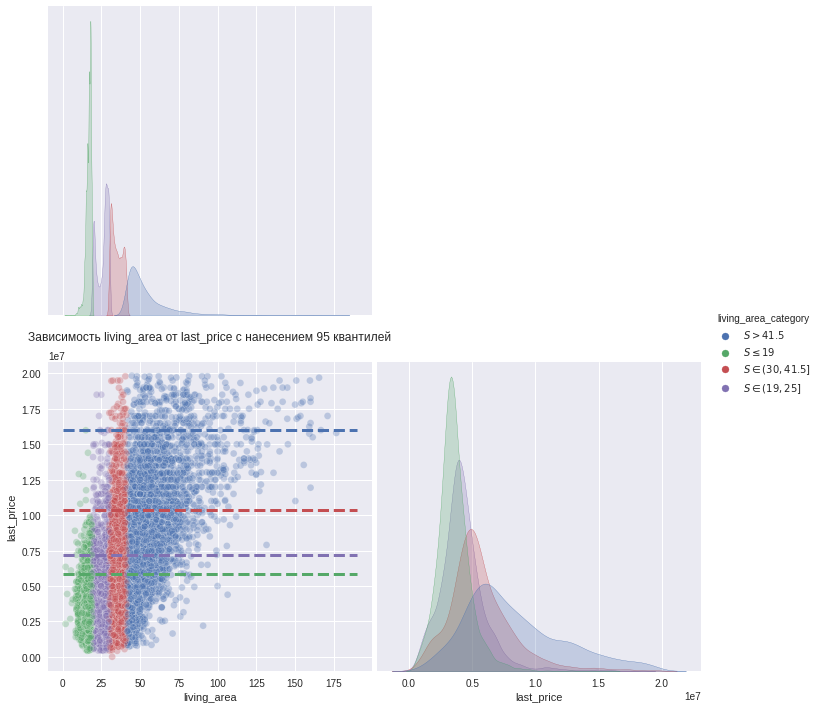

In [479]:
g = sns.pairplot(
    df,
    vars=["living_area", "last_price"],
    corner=True,
    hue="living_area_category",
    height=5,
    plot_kws={'alpha':0.3}
);

g.fig.subplots_adjust(hspace=0.15)

g.axes[1][0].set_title('Зависимость living_area от last_price с нанесением 95 квантилей', y=1.05)
for p in zip(g.palette, g.hue_names):
    g.axes[1][0].hlines(y=piv.loc[p[1], 'q95'], xmin=0, xmax=190, color=p[0], lw=3, ls='--') 

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
    
1. Цена зависит от площади жилой части квартиры. Особенно ярко это выражается для квартир с жилой площадью до 55 квадратных метров
2. Медианные значения различных по категории площади жилой части легко различимы
3. Верхняя отсечка по цене, по которой можно идентифицировать 95 процентов квартир в той или иной категории жилой части площади легко различимы на графике</div>

In [480]:
df.kitchen_area.quantile([0.25, 0.5, 0.75])

0.25     6.8
0.50     9.0
0.75    11.1
Name: kitchen_area, dtype: float64

In [481]:
def categorize_kitchen_area(area):
    if area <= 6.8:
        return '$S \\leq 6.8$'
    elif 6.8 < area <= 9:
        return '$S\\in (6.8, 9]$'
    elif 9 < area <= 11.1:
        return '$S\\in (9, 11.1]$'
    else:
        return '$S > 11.1$'

In [482]:
df['kitchen_area_category'] = df.kitchen_area.apply(categorize_kitchen_area)

In [483]:
piv = (df
       .pivot_table(index='kitchen_area_category', values='last_price', 
                    aggfunc={
                        'last_price': [('q5', lambda x: x.quantile(.05)),
                                       ('median', 'median'),
                                       ('count', 'count'), 
                                       ('q95', lambda x: x.quantile(.95))]}))
piv

,count,median,q5,q95
kitchen_area_category,,,,
$S > 11.1$,5663,7300000.0,3300000.0,16000000.0
$S \leq 6.8$,5754,3450000.0,1300000.0,5900000.0
"$S\in (6.8, 9]$",6644,4220000.0,1750000.0,8250000.0
"$S\in (9, 11.1]$",4670,4900000.0,2694500.0,10500000.0


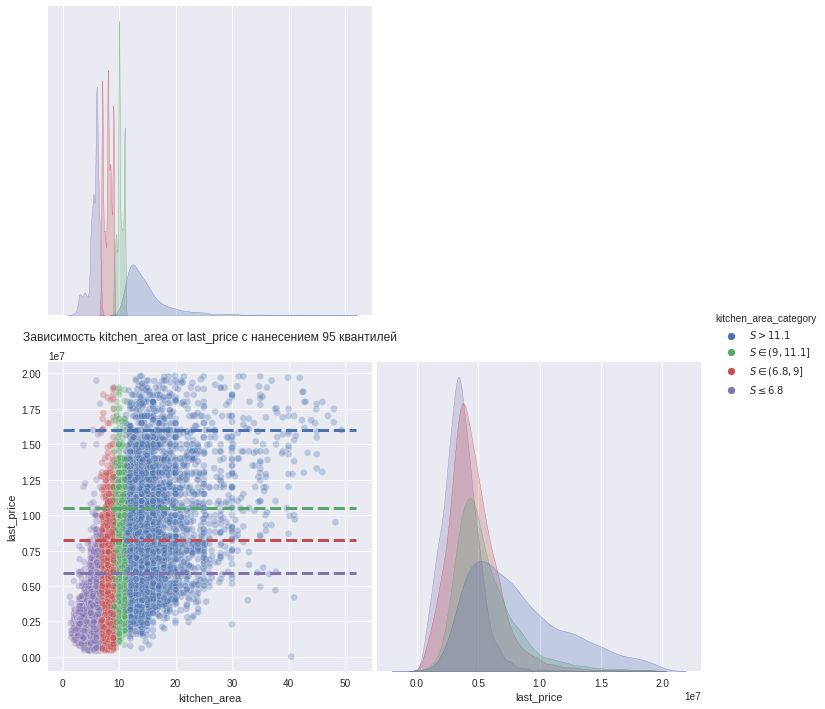

In [484]:
g = sns.pairplot(
    df,
    vars=["kitchen_area", "last_price"],
    corner=True,
    hue="kitchen_area_category",
    height=5,
    plot_kws={'alpha':0.3}
);

g.fig.subplots_adjust(hspace=0.15)

g.axes[1][0].set_title('Зависимость kitchen_area от last_price с нанесением 95 квантилей', y=1.05)
for p in zip(g.palette, g.hue_names):
    g.axes[1][0].hlines(y=piv.loc[p[1], 'q95'], xmin=0, xmax=52, color=p[0], lw=3, ls='--') 

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
    
1. Цена зависит от кухонной площади квартиры. Особенно ярко это выражается для квартир с кухонной площадью до 20 квадратных метров
2. Медианные значения различных по категории площади кухонной части достаточно хорошо различимы, хотя медианы категорий $S\in (6.8, 9]$ и $S\in (9, 11.1]$ отличаются несильно
3. Верхняя отсечка по цене, по которой можно идентифицировать 95 процентов квартир в той или иной категории жилой части площади легко различимы на графике</div>

In [485]:
piv = (df
       .pivot_table(index='rooms', values='last_price', 
                    aggfunc={
                        'last_price': [('q5', lambda x: x.quantile(.05)),
                                       ('median', 'median'),
                                       ('count', 'count'), 
                                       ('q95', lambda x: x.quantile(.95))]}).sort_values('median'))
piv

,count,median,q5,q95
rooms,,,,
0,187,2700000.0,1700000.0,4650000.0
1,7957,3600000.0,1700000.0,6490871.4
2,7788,4750000.0,1700000.0,10681250.0
3,5499,6000000.0,2500000.0,14000000.0
4,996,8150000.0,3280000.0,17097500.0
5,221,11000000.0,4600000.0,17900000.0
6,56,13375000.0,8091000.0,19500000.0
7,20,15175000.0,11795000.0,18000000.0
10,1,15500000.0,15500000.0,15500000.0


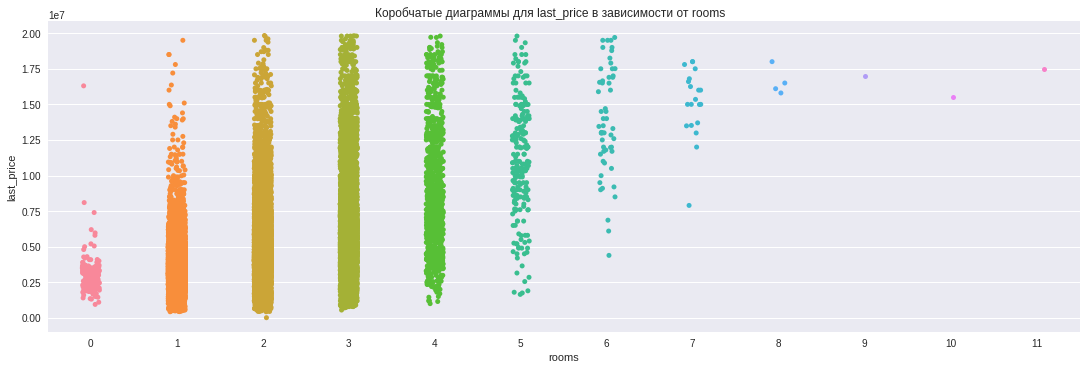

In [486]:
g = sns.catplot(
    data=df[['total_area_group', "rooms", "last_price"]],
    x="rooms",
    y="last_price",
    aspect=3,
).fig.suptitle('Коробчатые диаграммы для last_price в зависимости от rooms')

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
На графике плотность точек поднимается при увеличении числа комнат, медиана растет в зависимости от роста количества комнат (справедливо для с 1 по 5 этаж, дальше либо порядок нарушается, либо количество точек не позволяет делать обобщающих выводов)</div>

In [487]:
piv = (df
       .pivot_table(index='floor_category', values='last_price', 
                    aggfunc={
                        'last_price': [('q5', lambda x: x.quantile(.05)),
                                       ('median', 'median'),
                                       ('count', 'count'), 
                                       ('q95', lambda x: x.quantile(.95))]}).sort_values('median'))
piv

,count,median,q5,q95
floor_category,,,,
первый,2823,3900000.0,1350000.0,9145000.0
последний,3175,4200000.0,1350000.0,12500000.0
другой,16733,4750000.0,2200000.0,12611940.0


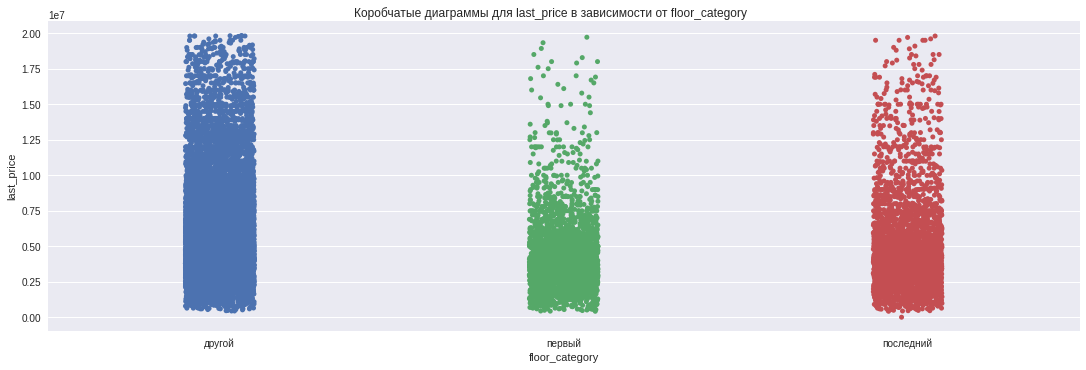

In [488]:
g = sns.catplot(
    data=df[['floor_category', "last_price"]],
    x="floor_category",
    y="last_price",
    aspect=3,
).fig.suptitle('Коробчатые диаграммы для last_price в зависимости от floor_category')

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Здесь отчетливо видно, что цена квартиры, которая находится не на первом и не на последнем этаже самая высокая, кроме того таких квартир большинство. Также можно увидеть, что самыми дешевыми являются квартиры на первом этаже, плотность точек на среднем графике сильно падает с ростом цены на квартиру</div>

In [489]:
piv = (df
       .pivot_table(index='first_day_exposition_weekday', values='last_price', 
                    aggfunc={
                        'last_price': [('q5', lambda x: x.quantile(.05)),
                                       ('median', 'median'),
                                       ('count', 'count'), 
                                       ('q95', lambda x: x.quantile(.95))]}).sort_values('median'))
piv

,count,median,q5,q95
first_day_exposition_weekday,,,,
4,3852,4500000.0,1950000.0,12000000.0
5,1865,4500000.0,1600000.0,11880000.0
6,1626,4500000.0,1755000.0,11500000.0
0,3450,4550000.0,1900000.0,12000000.0
3,4094,4550000.0,1806500.0,12800000.0
2,3811,4600000.0,1900000.0,12500000.0
1,4033,4650000.0,1900000.0,12494000.0


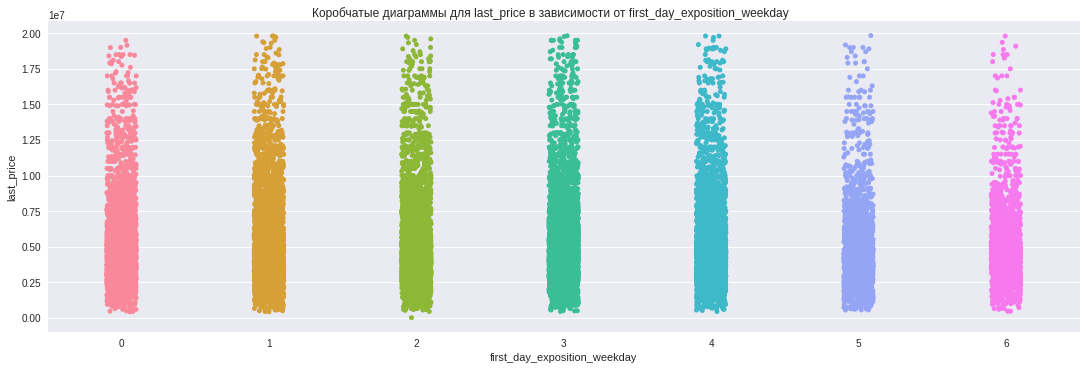

In [490]:
g = sns.catplot(
    data=df[['first_day_exposition_weekday', "last_price"]],
    x="first_day_exposition_weekday",
    y="last_price",
    aspect=3
).fig.suptitle('Коробчатые диаграммы для last_price в зависимости от first_day_exposition_weekday')

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
В целом, большой зависимости от дня публикации объявления нет, однако наблюдается небольшой провал в плотности точек в пятницу и субботу в области высоких цен на квартиру</div>

In [491]:
(df
 .pivot_table(index='first_day_exposition_month', values='last_price', 
              aggfunc={
                  'last_price': [('q5', lambda x: x.quantile(.05)),
                                 ('median', 'median'),('count', 'count'), 
                                 ('q95', lambda x: x.quantile(.95))]})
 .sort_values('median'))

,count,median,q5,q95
first_day_exposition_month,,,,
Июнь,1682,4310000.0,1700000.0,11749911.25
Август,1680,4500000.0,1850000.0,12239036.45
Май,1213,4500000.0,1974000.0,12500000.00
Октябрь,2054,4500000.0,1850000.0,12493150.00
Январь,1420,4500000.0,1746265.0,12204400.00
Июль,1623,4550000.0,1800000.0,12490000.00
Март,2493,4585000.0,1850000.0,12538760.00
Февраль,2539,4590000.0,1850000.0,12000000.00
Декабрь,1561,4600000.0,1800000.0,11940000.00


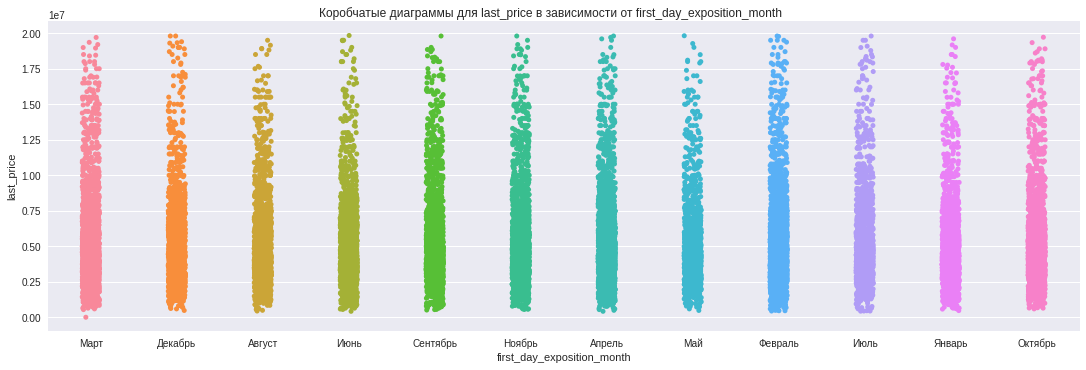

In [492]:
g = sns.catplot(
    data=df[['first_day_exposition_month', "last_price"]],
    x="first_day_exposition_month",
    y="last_price",
    aspect=3,
).fig.suptitle('Коробчатые диаграммы для last_price в зависимости от first_day_exposition_month')

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
В целом, большой зависимости от месяца публикации объявления нет</div>

In [493]:
(df
 .pivot_table(index='first_day_exposition_year', values='last_price', 
              aggfunc={
                  'last_price': [('q5', lambda x: x.quantile(.05)),
                                 ('median', 'median'),('count', 'count'), 
                                 ('q95', lambda x: x.quantile(.95))]})
 .sort_values('median'))


,count,median,q5,q95
first_day_exposition_year,,,,
2017,7865,4400000.0,1900000.00,12000000.0
2016,2645,4450000.0,1991000.00,12500000.0
2018,8248,4500000.0,1719257.05,11743000.0
2019,2764,4990000.0,1850000.00,12700000.0
2015,1097,5100000.0,2100000.00,14128000.0
2014,112,6625000.0,2459450.00,17497500.0


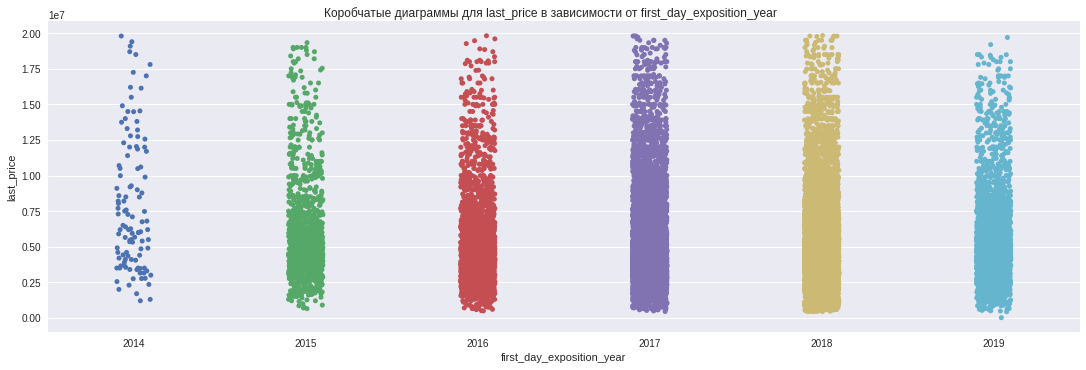

In [494]:
g = sns.catplot(
    data=df[['first_day_exposition_year', "last_price"]],
    x="first_day_exposition_year",
    y="last_price",
    aspect=3,
).fig.suptitle('Коробчатые диаграммы для last_price в зависимости от first_day_exposition_year')

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Хотя и видно, что в 2014 году точки расположены весьма разрежено, выводов делать нельзя, так как по данной категории есть всего лишь 112 объявлений. В 2017 и 2018 году активнее выкладывались квартиры с высокой ценой, хуже дела обстояли в 2016, 2019, в 2015 году в основном на продаже выкладывались квартиры с ценой до 7.5 млн рублей</div>

#### Топ10 населенных пунктов по цене за квадратный метр

In [495]:
piv_df = (df
          .pivot_table(index='locality_name', values='price_per_square', aggfunc=['mean', 'count'])
          .set_axis(['mean', 'count'], axis=1)
          .sort_values('count', ascending=False)[:10])
piv_df

,mean,count
locality_name,,
Санкт-Петербург,108480.725820,14899
Мурино,86009.154798,580
Кудрово,95375.983021,469
Шушары,78610.899800,438
Всеволожск,67187.008876,392
Пушкин,101876.490429,355
Колпино,75408.562836,335
Парголово,90135.075586,326
Гатчина,68625.141404,303


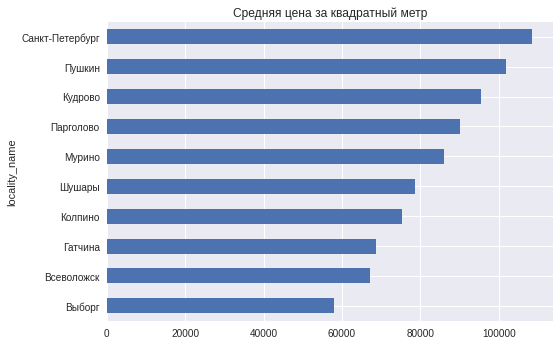

In [496]:
piv_df['mean'].sort_values().plot(kind='barh', title='Средняя цена за квадратный метр')
plt.show()

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Дороже всего квадратный метр стоит в Санкт-Петербурге, дешевле всего в топ10 по количеству объявлений - в Выборге</div>

#### Исследование влияния удаленности от центра Петербурга на цену продажи квартиры

In [497]:
df.cityCenters_nearest_km = df.cityCenters_nearest_km.apply(np.ceil)

In [498]:
(df
 .query('locality_name == "Санкт-Петербург"')
 .pivot_table(index=['cityCenters_nearest_km'], values='last_price', aggfunc='mean'))

,last_price
cityCenters_nearest_km,
1.0,1.002143e+07
2.0,1.019553e+07
3.0,9.578043e+06
4.0,9.073957e+06
5.0,9.566786e+06
6.0,8.814767e+06
7.0,8.127791e+06
8.0,7.999118e+06
9.0,7.285828e+06


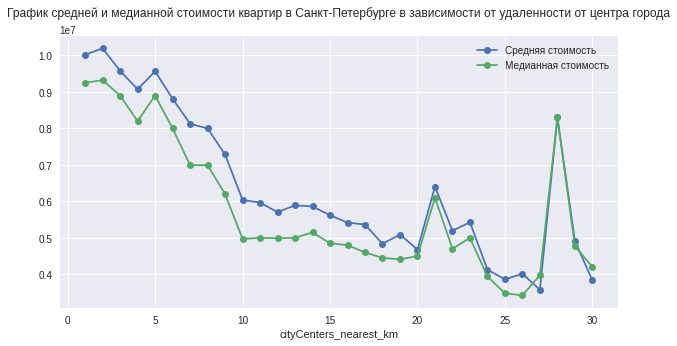

In [499]:
(df
 .query('locality_name == "Санкт-Петербург"')
 .pivot_table(index=['cityCenters_nearest_km'], values='last_price', aggfunc=['mean', 'median'])
 .set_axis(['Средняя стоимость', 'Медианная стоимость'], axis=1)
 .plot(figsize=(10, 5), marker='o'))
plt.title('График средней и медианной стоимости квартир в Санкт-Петербурге в зависимости от удаленности от центра города', y=1.05)
plt.show()

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Из графика явно видна тенденция (до 20 км): чем больше расстояние, тем меньше стоимость. Однако есть два подозрительных пика в районе 21 км и 27 км. Причем они видны на обоих графиках, раз похожие значения показывает медиана, то нужно посмотреть, что это за квартиры</div>

<div style="color:#FCFAEE ;background-color:#507687" class="alert alert-block alert-info"> 
Хороший вопрос, по графику видно, что в самом центре квартиры дешевле (возможно, из-за их состояния). Исторический центр Санкт-Петербурга, если верить картам, имеет 2 км радиус. Если взять гипотезу о дешевых ветхих домах в центральном районе, то график показывают приблизительно ту же границу центральной зоны
</div>

In [500]:
(df
 .query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km == 21')
 .pivot_table(index=['total_area_group', 'floors_total', 'floor_category'], values=['last_price'], aggfunc=['median', 'mean', 'count'])
 .set_axis(['median', 'mean', 'count'], axis=1)
 .query('count > 2')
)

median          mean  count
total_area_group floors_total floor_category                                
$S \geq 70$      3            последний       9635328.0  9.394806e+06      5
                 4            другой          9432994.0  9.027562e+06      4
                 35           другой          9550000.0  9.076778e+06     10
$S\in(20; 40]$   35           другой          3570000.0  3.722500e+06      4
$S\in(40; 52]$   4            другой          5289476.0  5.367818e+06      5
                 35           другой          5500000.0  5.477800e+06      5
$S\in(52; 70]$   4            другой          6208824.0  6.443420e+06      9
                 9            другой          5725000.0  5.537500e+06      4
                 12           другой          5300000.0  5.347500e+06      4
                 35           другой          6990000.0  6.850556e+06      9

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Судя по всему, большинство  квартир находятся в элитном жк Александр Невский, поэтому средняя и медианные цены столь высокие</div>

In [501]:
(df
 .query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km == 28')
 .pivot_table(index=['total_area_group', 'floors_total', 'floor_category'], values=['last_price'], aggfunc=['median', 'mean', 'count'])
 .set_axis(['median', 'mean', 'count'], axis=1)
)

,,,median,mean,count
total_area_group,floors_total,floor_category,,,
$S \geq 70$,5,другой,14350000.0,14350000.0,1
$S\in(20; 40]$,2,последний,2250000.0,2250000.0,1


<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
Касательно сильного пика на 28 км от центра, это две квартиры: одна в пятиэтажке и одна в двухэтажном доме</div>

### Напишите общий вывод

<div style="color:#630d61 ;background-color:#d3ebfa" class="alert alert-block alert-info"> 
    
1. Была проведена предобработка данных в ходе которого часть данных была заполнена дефолтными значениями, а меньшая часть удалена из датасета. Не все столбцы с пропусками удалось заполнить по техническим причинам, для из заполнения требуется дополнительная информация. Было также выяснено, что большая часть квартир не является апартаментами, если судить по типу планировки и медианному значению цены, сгруппированному по категории общей площади. Была выяснена взаимосвязь географических пропусков, большая часть которых строках с квартирами, находящихся в селах и деревнях. Были устранены странные квартиры, в которых суммарная площадь жилой и кухонных частей были больше чем указанная общая площадь. Также были обработаны аномалии (метод межквартильного размаха и отсечка по длинному хвосту распределения) и дубликаты в столбце с названиями населенных пунктов.
    
2. Были добавлены новые столбцы, по части которых проводился исследовательский анализ данных

3. Была оценена степень влияния различных факторов на цену продажи квартиры. Оказалось, что наибольшее влияние имеет признак - общая площадь. Влияния исследовалось с помощью коэффициента корреляции Пирсона. А, например, месяц и день недели, когда выставили объявление, практически никак не влияет на цену квартиры.

4. Произведена оценка скорости продажи квартир и выявлены типичное значение (89 дней) и границы, выход за которые может считаться слишком быстрой или слишком медленно продажей ([30, 215])
    
5. Выявлено, что самая большая средняя цена за квадратный метр в Санкт-Петербурге, а самая маленькая - в Выборге.

6. Исследована зависимость средней цены квартиры в Санкт-Петербурге в зависимости от удаленности от центра. Оказалось, что тенденция следующая: чем ближе к центру - тем больше стоимость квартиры, за исключением нескольких элитных жк и небольших домов в достаточном удалении от центра города
</div>